# Data cleaning2
## Note: Some description about why I addressed the specific columns this way is in EDA file.

# Import module and set basic items

In [1]:
'''import module'''

# basic tool
import os
from functools import reduce
import random

# data process and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# style and text
from matplotlib.font_manager import FontProperties

# fit model and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# working dir
working_path = r"D:\mypython_d\Cathay_Big_data_competition_2019"
os.chdir(working_path)

In [3]:
# use big5 to encoding
train = pd.read_csv("train_clean1.csv", encoding="Big5", low_memory=False, index_col=0)

In [4]:
# set figure style
sns.set_style("whitegrid")
# set text
font = FontProperties(fname=r"c:\windows\Fonts\msjh.ttc")
font_heavy = FontProperties(fname=r"c:\windows\Fonts\msjhbd.ttc")
font_big = FontProperties(fname=r"c:\windows\Fonts\msjhbd.ttc", size= "x-large")
font_kibig = FontProperties(fname=r"c:\windows\Fonts\msjhbd.ttc", size= "large")

In [5]:
# show countplot, and rate of hue
def count_and_percent(col, data, hue, size=None):
    
    plt.figure(figsize=size)
    sns.countplot(x=col, data=data, palette="viridis")
    # change font
    plt.xticks(fontproperties=font_heavy)
    
    plt.figure(figsize=size)
    sns.countplot(x=col, data=data, hue=hue, palette="viridis")
    
    # change font
    plt.xticks(fontproperties=font_heavy)
    plt.legend(prop=font_heavy)
    
    plt.show()
    for cat in data[col].unique():
        show_percent(cat, col, data, hue)
    
def show_percent(category, col, data, hue):
    print("-------------------------------")
    print(str(category) + ":")
    if  repr(category) != "nan":
        value_info = data[data[col] == category][hue].value_counts()
        print(value_info)
        for hue_cat in sorted(value_info.keys()):
            print(str(hue_cat) + "(%):", (value_info[hue_cat]/value_info.sum()) * 100 )
    else:
        value_info = data[data[col].isnull()][hue].value_counts()
        print(value_info)
        for hue_cat in sorted(value_info.keys()):
            print(str(hue_cat) + "(%):", (value_info[hue_cat]/value_info.sum()) * 100 )

In [6]:
# 備份最原始的檔案
train_copy = pd.read_csv("train.csv", encoding="Big5", low_memory=False)

# Imputation data

In [7]:
impute_dataset = pd.read_csv("impute_dataset.csv", index_col=0)

In [8]:
# 運用Extratrees觀察重要性
def importance_measure(col, seed=111, max_test=7, algorithm=ExtraTreesClassifier(random_state=111)):
    y = train[col].dropna(axis=0)
    X_train, X_test, y_train, y_test = train_test_split(impute_dataset.loc[y.index],
                                                        y, test_size=0.2, random_state=seed)
    impo_model = algorithm
    impo_model.fit(X_train, y_train)
    impo = list(zip(X_train.columns, impo_model.feature_importances_))
    impo.sort(reverse=True, key=lambda x: x[1])
    print("重要性排序:", np.array(impo)[:, 0])
    print("-----------------------------------")
    report(col, seed, np.array(impo)[:, 0], max_test, y, algorithm)
    
def report(col, seed, important_col, max_test, y, algorithm):
    
    for num_col in range(1, max_test + 1):
        print("測試欄位數:", num_col)
        X = impute_dataset[np.array(important_col[:num_col])]
        X_train, X_test, y_train, y_test = train_test_split(X.loc[y.index], y, test_size=0.2, random_state=seed)
        imp_model = algorithm
        imp_model.fit(X_train, y_train)
        pred = imp_model.predict(X_test)
        try:
            print(classification_report(y_test, pred))
            print(accuracy_score(y_test, pred))
        except ValueError:
            MSE = mean_squared_error(y_test, pred)
            print("MSE:", MSE)
            print("RMSE:", np.sqrt(MSE))
        print("-----------------------------------")
        
def impute(important_cols, impute_col, algorithm=ExtraTreesClassifier(random_state=111)):
    null_data = train[pd.isnull(train[impute_col])]
    value_data = train[impute_col].dropna(axis=0)
    
    imp = algorithm
    imp.fit(train[important_cols].loc[value_data.index], value_data)
    null_data[impute_col] = imp.predict(train[important_cols].loc[null_data.index])
    train["tempor"] = null_data[impute_col]
    train[impute_col] = train[[impute_col, "tempor"]].apply(impute_function, axis=1)
    train.drop("tempor", axis=1, inplace=True)
    
    return imp

def impute_function(cols):
    
    target = cols[0]
    predictor = cols[1]
    
    if pd.isnull(predictor):
        return target
    
    else:
        return predictor

In [9]:

def important_test(col, test_time=10, algorithm=ExtraTreesClassifier(random_state=111)):
    
    test_list = []
    seed_list = [random.randint(0, 10000) for i in range(test_time)]
    
    for seed in seed_list:
        y = train[col].dropna(axis=0)
        X_train, X_test, y_train, y_test = train_test_split(impute_dataset.loc[y.index],
                                                            y, test_size=0.2, random_state=seed)
        impo_model = algorithm
        impo_model.fit(X_train, y_train)
        impo = list(zip(X_train.columns, impo_model.feature_importances_))
        impo.sort(reverse=True, key=lambda x: x[1])
        
        for important_ele in np.array(impo)[:10, 0]:
            test_list.append(important_ele)
    
    result = [(ele, test_list.count(ele)) for ele in set(test_list)]
    result.sort(reverse=True, key=lambda x: x[1])
    
    print(result)
    return result, seed_list


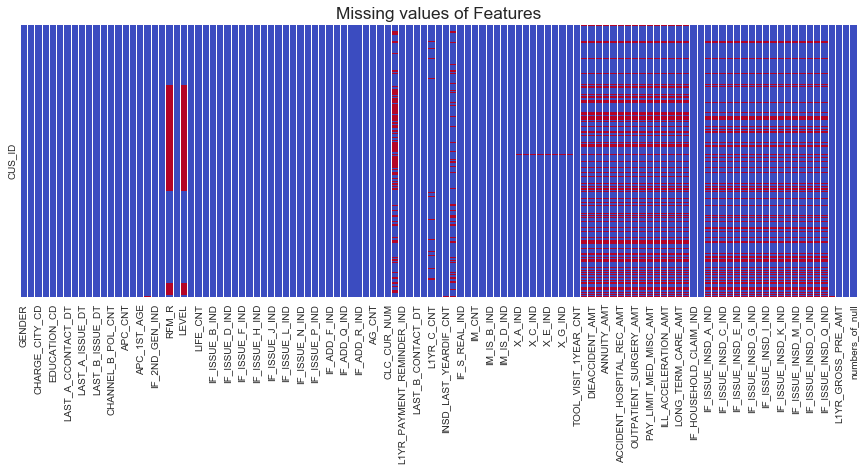

In [49]:
# Nan figure(red:Nan) of train
plt.figure(figsize=[15, 5])
plt.title("Missing values of Features", fontdict={"fontsize":"xx-large"})
sns.heatmap(train.drop("Y1", axis=1).isnull(), yticklabels=False, cbar=False, cmap="coolwarm")

In [10]:
# 有遺失值欄位個數
len(train.columns[pd.isnull(train).sum() != 0])

48

# IF_ADD_INSD_IND(是否投保附約(被保) ) 
* 171遺失值

* 和IF_ADD_INSD_*_IND目前是否壽險保單被保有效類別_*(附約)系列有關

* 遺失值代表非被保險人，最後階段處理時刪除此171遺失值
* 由於此欄位會被刪除，所以後續由非被保人在其他欄位所產生之遺失值未必會刻意去辨識出

NOTE:這裡刪除掉171筆資料，等於放棄捕捉非被保險人(純要保人)這類人特有的特徵，雖然實際上這類人屬少類，所以在test資料集中，應該也屬少數，不會影響到整體表現，但仍要特別注意這部分。(若此欄位未刪，附帶的後面一些欄位有牽扯到的可能要特別再處理)
ex.IF_ISSUE_INSD_*_IND系列

In [658]:
temporary_col = pd.read_csv("temporary_col.csv", index_col=0)
temporary_col["IF_ADD_INSD_IND"] = train["IF_ADD_INSD_IND"]

In [659]:
# 皆也為NAN
temporary_col[pd.isnull(temporary_col["IF_ADD_INSD_IND"])][["IF_ADD_INSD_F_IND", "IF_ADD_INSD_L_IND", "IF_ADD_INSD_Q_IND", 
                                           "IF_ADD_INSD_G_IND", "IF_ADD_INSD_R_IND"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 1034973 to 1994377
Data columns (total 5 columns):
IF_ADD_INSD_F_IND    0 non-null float64
IF_ADD_INSD_L_IND    0 non-null float64
IF_ADD_INSD_Q_IND    0 non-null float64
IF_ADD_INSD_G_IND    0 non-null float64
IF_ADD_INSD_R_IND    0 non-null float64
dtypes: float64(5)
memory usage: 8.0 KB


In [660]:
train["IF_ADD_INSD_IND"].value_counts()

0.0    51853
1.0    47976
Name: IF_ADD_INSD_IND, dtype: int64

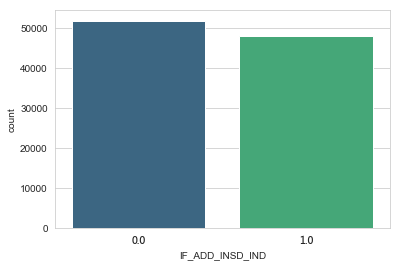

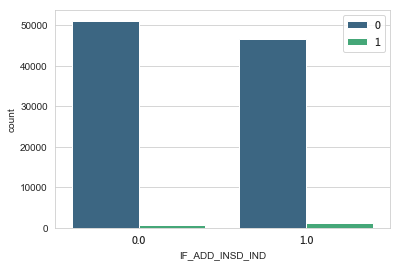

-------------------------------
0.0:
0    51147
1      706
Name: Y1, dtype: int64
0(%): 98.63845871984263
1(%): 1.3615412801573679
-------------------------------
1.0:
0    46746
1     1230
Name: Y1, dtype: int64
0(%): 97.43621810905452
1(%): 2.5637818909454726
-------------------------------
nan:
0    107
1     64
Name: Y1, dtype: int64
0(%): 62.57309941520468
1(%): 37.42690058479532


In [661]:
count_and_percent("IF_ADD_INSD_IND", train, "Y1")

# RFM_R 上次要保人身份投保距今間隔時間(年)(級距) 
* 共有43294遺失值
* 研究與推測為"非要保人的遺失值欄位" =>驗證前述假設，RFM_R 列為"非要保人的遺失值欄位"系列
* 43282筆資料採用和前述一樣方式，將這些遺失值視為一類別(0)，而12筆剩餘資料另外觀察、處理。


In [12]:
sum(train["RFM_R"].isnull())

43294

In [11]:
train["RFM_R"].value_counts()

1.0    17506
3.0    14616
4.0    12293
2.0    12291
Name: RFM_R, dtype: int64

In [663]:
rfm_exper = pd.DataFrame(train_copy[["CUS_ID", "APC_1ST_AGE", "APC_1ST_YEARDIF", 
                                     "REBUY_TIMES_CNT", "RFM_M_LEVEL", "TERMINATION_RATE", "RFM_R"]],
                        columns=["CUS_ID", "APC_1ST_AGE", "APC_1ST_YEARDIF", 
                                 "REBUY_TIMES_CNT", "RFM_M_LEVEL", "TERMINATION_RATE", "RFM_R"],)
rfm_exper.set_index("CUS_ID", inplace=True)

In [664]:

print("ap為遺失值，但RFM不是:", sum(rfm_exper[pd.isnull(rfm_exper["APC_1ST_AGE"])]["RFM_R"].value_counts()))
print("RFM為遺失值，但ap不是:", sum(rfm_exper[pd.isnull(rfm_exper["RFM_R"])]["APC_1ST_AGE"].value_counts()))

ap為遺失值，但RFM不是: 0
RFM為遺失值，但ap不是: 12


In [665]:
# 補值
def RFM_R_impute(cols):
    
    APC_1ST_AGE = cols[0]
    RFM_R = cols[1]
    
    if pd.isnull(APC_1ST_AGE) and pd.isnull(RFM_R):
        return 0
    
    else:
        return RFM_R
        

In [666]:
train["RFM_R"] = rfm_exper[["APC_1ST_AGE", "RFM_R"]].apply(RFM_R_impute, axis=1)

In [667]:
train['RFM_R']= train['RFM_R'].map({'中':2,'中高':3,'低':1,'高':4, 0:0})

In [668]:
# check
abs(sum(train["RFM_R"].value_counts())-100000)

12

## 例外管理:12筆資料 (可刪除=>最後一起來刪)

In [669]:
rfm_exc = train.loc[rfm_exper[pd.isnull(rfm_exper["RFM_R"])]["APC_1ST_AGE"].dropna().index]

In [670]:
rfm_exc.info(max_cols=150)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 1748547 to 2411609
Data columns (total 116 columns):
GENDER                       12 non-null float64
AGE                          12 non-null int64
CHARGE_CITY_CD               12 non-null int64
CONTACT_CITY_CD              12 non-null int64
EDUCATION_CD                 12 non-null float64
MARRIAGE_CD                  12 non-null float64
LAST_A_CCONTACT_DT           12 non-null int64
L1YR_A_ISSUE_CNT             12 non-null int64
LAST_A_ISSUE_DT              12 non-null int64
L1YR_B_ISSUE_CNT             12 non-null int64
LAST_B_ISSUE_DT              12 non-null int64
CHANNEL_A_POL_CNT            12 non-null int64
CHANNEL_B_POL_CNT            12 non-null int64
OCCUPATION_CLASS_CD          12 non-null float64
APC_CNT                      12 non-null int64
INSD_CNT                     12 non-null int64
APC_1ST_AGE                  12 non-null float64
INSD_1ST_AGE                 12 non-null float64
IF_2ND_GEN_IND             

In [671]:
rfm_exc["Y1"]

CUS_ID
1748547    0
2110306    1
1865913    0
905488     0
1920227    0
577363     0
664195     0
1469969    0
1618434    0
1658761    0
1811633    1
2411609    0
Name: Y1, dtype: int64

# LEVEL(往來關係等級)
共有43305遺失值
分成幾類(已得到各式證據驗證):
1. 非要保人 43281=>不是要保人所以沒有和任何通路接觸=>所以沒有往來關係 (有1筆非要保人但有值=>因為近三年有與A通路接觸)
2. 剩餘(24)=>其他原因遺失值


In [672]:
train["LEVEL"].value_counts()

5.0    28415
1.0    13940
4.0     6490
3.0     4041
2.0     3809
Name: LEVEL, dtype: int64

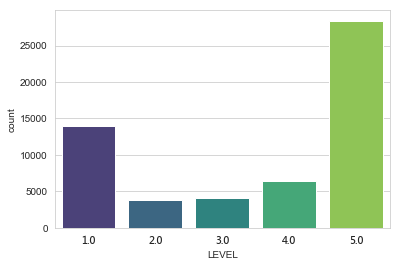

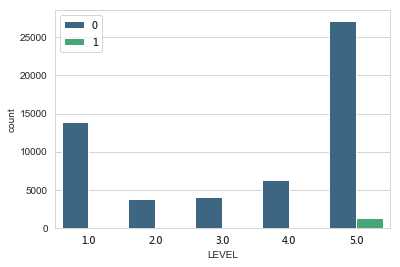

-------------------------------
3.0:
0    3992
1      49
Name: Y1, dtype: int64
0(%): 98.787428854244
1(%): 1.212571145756001
-------------------------------
5.0:
0    27181
1     1234
Name: Y1, dtype: int64
0(%): 95.65722329755411
1(%): 4.342776702445891
-------------------------------
2.0:
0    3744
1      65
Name: Y1, dtype: int64
0(%): 98.29351535836177
1(%): 1.7064846416382253
-------------------------------
1.0:
0    13845
1       95
Name: Y1, dtype: int64
0(%): 99.31850789096126
1(%): 0.6814921090387375
-------------------------------
4.0:
0    6323
1     167
Name: Y1, dtype: int64
0(%): 97.42681047765794
1(%): 2.573189522342065
-------------------------------
nan:
0    42915
1      390
Name: Y1, dtype: int64
0(%): 99.09941115344648
1(%): 0.9005888465535158


In [673]:
count_and_percent("LEVEL", train, "Y1")

In [674]:
# 確認和"非要保人的遺失值欄位"有無關係
level_exper = pd.DataFrame(train_copy[["CUS_ID", "APC_1ST_AGE", "APC_1ST_YEARDIF", 
                                     "REBUY_TIMES_CNT", "RFM_M_LEVEL", "TERMINATION_RATE", "LEVEL"]],
                        columns=["CUS_ID", "APC_1ST_AGE", "APC_1ST_YEARDIF", 
                                 "REBUY_TIMES_CNT", "RFM_M_LEVEL", "TERMINATION_RATE", "LEVEL"],)
level_exper.set_index("CUS_ID", inplace=True)

In [675]:
print("ap為遺失值，但LEVEL不是:", sum(level_exper[pd.isnull(level_exper["APC_1ST_AGE"])]["LEVEL"].value_counts()))
print("LEVEL為遺失值，但ap不是:", sum(level_exper[pd.isnull(level_exper["LEVEL"])]["APC_1ST_AGE"].value_counts()))

ap為遺失值，但LEVEL不是: 1
LEVEL為遺失值，但ap不是: 24


## 補充:驗證非要保人

**見EDA (16-1)**

## 推論:
非要保人(簽約人)的人，一般不太會和保險公司人員有所接觸，故往來關係等級為None，1個例外仍然有辦法解釋，因為身為被保人仍可能和一些人員有所接觸，而產生這樣的紀錄(和EDA的資訊互相扣住了，所以可以相信)。或者是更精確的說，由於和保險公司直接接觸的都是要保人，因此紀錄也多紀錄再要保人這邊，被保人這邊相對的就沒有紀錄，但可能是被保人和要保人同時接觸，因此被保人透過要保人和公司接觸，並不代表被保人和公司沒有接觸，所以事實上可能這類人的"直接"往來關係是最下等，但實際上往來關係是和對應的要保人綁在一起的。綜上述這裡不將此類None當作是最下階的關係等級，而是同前面其他欄位一樣新增為一類別。而剩下24個遺失值視為NAN後續另外處理。

In [676]:
##### ID:2032588(cf.EDA=>這個人剛好也是唯一一個近三年有和A通路接觸的人)
level_exper[pd.isnull(level_exper["APC_1ST_AGE"])]["LEVEL"].dropna()

CUS_ID
2032588    5.0
Name: LEVEL, dtype: float64

In [677]:
train.loc[2032588]

GENDER                     0.00000
AGE                        2.00000
CHARGE_CITY_CD             4.00000
CONTACT_CITY_CD            4.00000
EDUCATION_CD               3.00000
MARRIAGE_CD                1.00000
LAST_A_CCONTACT_DT         1.00000
L1YR_A_ISSUE_CNT           0.00000
LAST_A_ISSUE_DT            0.00000
L1YR_B_ISSUE_CNT           0.00000
LAST_B_ISSUE_DT            0.00000
CHANNEL_A_POL_CNT          0.00000
CHANNEL_B_POL_CNT          0.00000
OCCUPATION_CLASS_CD        1.00000
APC_CNT                    1.00000
INSD_CNT                   0.00000
APC_1ST_AGE                0.00000
INSD_1ST_AGE               3.00000
IF_2ND_GEN_IND             0.00000
APC_1ST_YEARDIF            0.00000
RFM_R                      0.00000
REBUY_TIMES_CNT            0.00000
LEVEL                      5.00000
RFM_M_LEVEL                0.00000
LIFE_CNT                   1.00000
IF_ISSUE_A_IND             0.00000
IF_ISSUE_B_IND             0.00000
IF_ISSUE_C_IND             0.00000
IF_ISSUE_D_IND      

## 處理
* 非要保人43281直接設為一類別
* 剩餘24名可考慮直接刪除

**注意:經調整後此欄位變成名目尺度**

In [678]:
def LEVEL_impute(cols):
    
    APC_1ST_AGE = cols[0]
    LEVEL = cols[1]
    
    if pd.isnull(LEVEL) and pd.isnull(APC_1ST_AGE):
        return 0
    
    else:
        return LEVEL

In [679]:
train["LEVEL"] = level_exper[["APC_1ST_AGE", "LEVEL"]].apply(LEVEL_impute, axis=1)

In [680]:
# 剩餘
len(train[train["LEVEL"].isnull()]["LEVEL"])

24

## 例外管理:24筆資料 =>最後階段可考慮刪除

In [681]:
train[train["LEVEL"].isnull()].info(max_cols=150)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 261871 to 1849613
Data columns (total 116 columns):
GENDER                       24 non-null float64
AGE                          24 non-null int64
CHARGE_CITY_CD               24 non-null int64
CONTACT_CITY_CD              24 non-null int64
EDUCATION_CD                 24 non-null float64
MARRIAGE_CD                  24 non-null float64
LAST_A_CCONTACT_DT           24 non-null int64
L1YR_A_ISSUE_CNT             24 non-null int64
LAST_A_ISSUE_DT              24 non-null int64
L1YR_B_ISSUE_CNT             24 non-null int64
LAST_B_ISSUE_DT              24 non-null int64
CHANNEL_A_POL_CNT            24 non-null int64
CHANNEL_B_POL_CNT            24 non-null int64
OCCUPATION_CLASS_CD          24 non-null float64
APC_CNT                      24 non-null int64
INSD_CNT                     24 non-null int64
APC_1ST_AGE                  24 non-null float64
INSD_1ST_AGE                 21 non-null float64
IF_2ND_GEN_IND              

In [682]:
train[train["LEVEL"].isnull()]["Y1"]

CUS_ID
261871     0
582636     0
1466831    0
498744     0
530613     0
778611     0
1104646    0
1125098    0
1216467    0
1258105    0
1487254    1
2359763    0
2459718    0
583162     0
1689275    0
2244038    0
1042035    0
745179     0
1898401    0
2476026    1
2509742    0
966336     0
1093408    1
1849613    0
Name: Y1, dtype: int64

# ANNUAL_INCOME_AMT(年收入 (神秘轉換&歸一化) )
* 年收入為生調表內容(填寫人:要保人、被保險人)
* 此欄位就和非要保人/非被保險人欄位沒什麼關係(根據EDA)
* 共有39201個遺失值
* 數值越高收入越高=>參考EDA資訊

In [683]:
sum(train["ANNUAL_INCOME_AMT"].isnull())

39201

In [684]:
des_ann = train["ANNUAL_INCOME_AMT"].describe()
print(des_ann)

count    60799.000000
mean         0.000607
std          0.001458
min          0.000000
25%          0.000250
50%          0.000417
75%          0.000667
max          0.250000
Name: ANNUAL_INCOME_AMT, dtype: float64


In [685]:
IQR = des_ann["75%"] - des_ann["25%"]

In [686]:
normal_value = train.loc[(train.loc[train["ANNUAL_INCOME_AMT"].dropna().index]["ANNUAL_INCOME_AMT"] < (des_ann["75%"])).index]

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


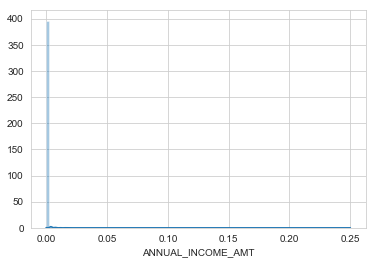

In [687]:
# 分配(大多很小)
sns.distplot(normal_value["ANNUAL_INCOME_AMT"] , bins=100)

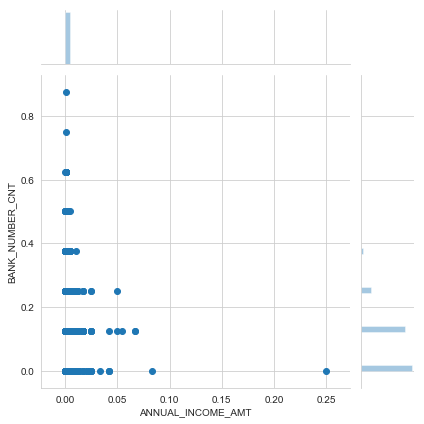

In [575]:
# 年收入vs往來銀行家數
sns.jointplot(x="ANNUAL_INCOME_AMT", y="BANK_NUMBER_CNT", data=train)

In [121]:
importance_measure("ANNUAL_INCOME_AMT", seed=111, max_test=25, algorithm=ExtraTreesRegressor(random_state=111))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


重要性排序: ['AG_CNT' 'LIFE_INSD_CNT' 'L1YR_GROSS_PRE_AMT' 'CUST_9_SEGMENTS_CD' 'AGE'
 'CONTACT_CITY_CD' 'CHANNEL_A_POL_CNT' 'TOOL_VISIT_1YEAR_CNT'
 'IF_ISSUE_P_IND' 'AG_NOW_CNT' 'APC_CNT' 'BANK_NUMBER_CNT' 'CLC_CUR_NUM'
 'INSD_CNT' 'CHARGE_CITY_CD' 'IF_HOUSEHOLD_CLAIM_IND' 'LIFE_CNT'
 'LAST_C_DT' 'IF_S_REAL_IND' 'IM_CNT' 'LAST_A_CCONTACT_DT'
 'IF_ISSUE_N_IND' 'IF_ISSUE_F_IND' 'IF_ISSUE_O_IND' 'LAST_B_CONTACT_DT'
 'IM_IS_B_IND' 'IF_ISSUE_I_IND' 'IF_2ND_GEN_IND' 'IM_IS_D_IND'
 'IF_ADD_F_IND' 'IF_ISSUE_D_IND' 'IF_ADD_IND' 'L1YR_PAYMENT_REMINDER_IND'
 'LAST_A_ISSUE_DT' 'IF_ADD_Q_IND' 'L1YR_LAPSE_IND' 'IF_ISSUE_J_IND'
 'IF_Y_REAL_IND' 'IF_ISSUE_Q_IND' 'IF_ADD_R_IND' 'IM_IS_C_IND'
 'IF_ISSUE_A_IND' 'IF_ISSUE_L_IND' 'CHANNEL_B_POL_CNT' 'IF_ADD_L_IND'
 'L1YR_A_ISSUE_CNT' 'IM_IS_A_IND' 'IF_ISSUE_C_IND' 'IF_ISSUE_B_IND'
 'IF_ISSUE_G_IND' 'IF_ISSUE_K_IND' 'IF_ISSUE_E_IND' 'IF_ADD_G_IND'
 'IF_ISSUE_M_IND' 'IF_ISSUE_H_IND' 'L1YR_B_ISSUE_CNT' 'LAST_B_ISSUE_DT']
-----------------------------------
測試欄位數:

In [152]:
important_test("ANNUAL_INCOME_AMT", test_time=50, algorithm=ExtraTreesRegressor(random_state=111))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


([('L1YR_GROSS_PRE_AMT', 50),
  ('AG_CNT', 50),
  ('AGE', 50),
  ('LIFE_INSD_CNT', 50),
  ('CUST_9_SEGMENTS_CD', 49),
  ('CONTACT_CITY_CD', 44),
  ('IF_HOUSEHOLD_CLAIM_IND', 38),
  ('CHARGE_CITY_CD', 33),
  ('AG_NOW_CNT', 26),
  ('TOOL_VISIT_1YEAR_CNT', 23),
  ('BANK_NUMBER_CNT', 20),
  ('CHANNEL_A_POL_CNT', 18),
  ('CLC_CUR_NUM', 13),
  ('LAST_C_DT', 7),
  ('LAST_A_CCONTACT_DT', 7),
  ('APC_CNT', 6),
  ('INSD_CNT', 6),
  ('IF_ISSUE_P_IND', 4),
  ('LIFE_CNT', 3),
  ('IF_ISSUE_N_IND', 2),
  ('IM_CNT', 1)],
 [6915,
  882,
  2595,
  6224,
  6667,
  7368,
  1585,
  5676,
  518,
  7783,
  1916,
  7839,
  4405,
  6755,
  4092,
  1611,
  7505,
  3078,
  8942,
  2691,
  4639,
  4694,
  2252,
  8413,
  8249,
  4523,
  4612,
  3246,
  255,
  4213,
  3846,
  2139,
  6029,
  9958,
  8521,
  3242,
  2561,
  8648,
  6980,
  2554,
  7631,
  9713,
  5237,
  8756,
  1375,
  2724,
  749,
  8462,
  304,
  352])

## 觀察重要性欄位與年收入
AG_CNT(曾經經手過的業務員人數)、LIFE_INSD_CNT(目前主約被保有效件數(件)(神秘轉))、BANK_NUMBER_CNT(銀行往來家數(轉帳)(神秘轉))都呈現數值越低的人傾向收入越高

In [688]:
# 曾經經手過的業務員人數 
train["AG_CNT"].value_counts()

0     43314
1     32822
2     14150
3      5706
4      2335
5       956
6       392
7       170
8        79
9        26
10       24
11       11
12        6
16        3
13        2
18        2
14        1
15        1
Name: AG_CNT, dtype: int64

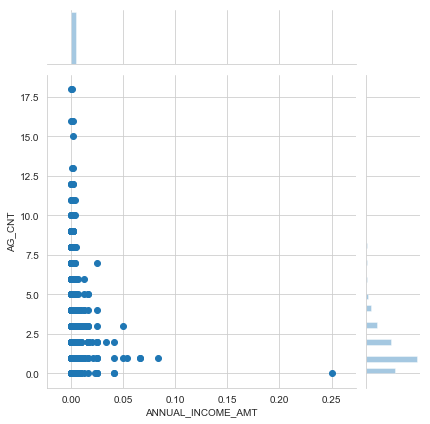

In [577]:
sns.jointplot(x="ANNUAL_INCOME_AMT", y="AG_CNT", data=train)

In [578]:
# 目前主約被保有效件數(件) (神秘轉換&歸一化) 
train["LIFE_INSD_CNT"].value_counts()

0.015625    31604
0.000000    20083
0.031250    19635
0.046875    12396
0.062500     6773
0.078125     3671
0.093750     2110
0.109375     1317
0.125000      774
0.140625      470
0.156250      324
0.171875      221
0.187500      134
0.203125      118
0.218750       79
0.234375       69
0.250000       46
0.265625       41
0.281250       20
0.296875       20
0.343750       13
0.359375       11
0.328125       11
0.375000        9
0.312500        9
0.390625        6
0.437500        5
0.406250        5
0.453125        4
0.421875        4
0.562500        2
0.546875        2
0.625000        2
0.484375        2
0.500000        2
0.468750        2
0.531250        1
0.875000        1
0.515625        1
0.921875        1
0.734375        1
0.687500        1
Name: LIFE_INSD_CNT, dtype: int64

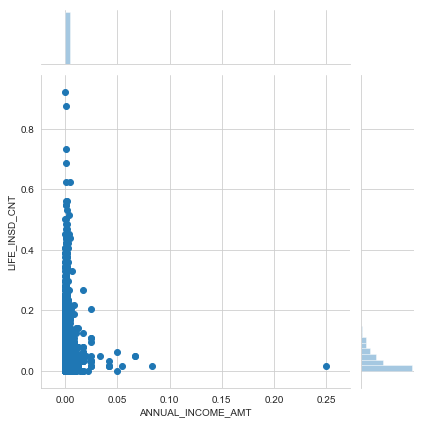

In [579]:
sns.jointplot(x="ANNUAL_INCOME_AMT", y="LIFE_INSD_CNT", data=train)

In [154]:
train["L1YR_GROSS_PRE_AMT"].value_counts()

0.000000    60988
0.000311       72
0.000140       63
0.000285       45
0.008625       41
0.000140       39
0.000025       35
0.000104       33
0.000021       32
0.000529       32
0.000474       31
0.000518       29
0.001058       28
0.000280       28
0.000207       28
0.000086       28
0.000052       27
0.000308       26
0.000519       26
0.000253       25
0.000280       25
0.000190       24
0.000354       23
0.000043       23
0.001402       21
0.000233       20
0.000210       20
0.000026       20
0.000017       19
0.000042       19
            ...  
0.001422        1
0.000346        1
0.000670        1
0.000407        1
0.000199        1
0.000596        1
0.000155        1
0.000355        1
0.000277        1
0.000698        1
0.004985        1
0.000166        1
0.000345        1
0.003573        1
0.000358        1
0.000159        1
0.000276        1
0.000269        1
0.000155        1
0.000545        1
0.000427        1
0.000481        1
0.001084        1
0.003918        1
0.001240  

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


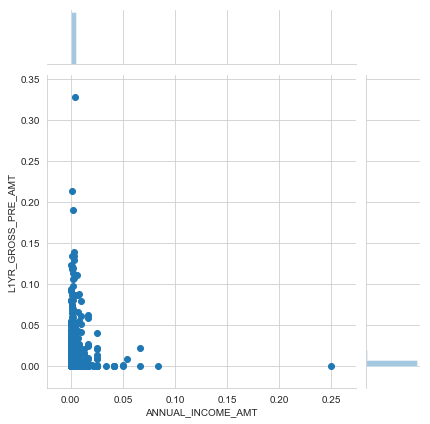

In [153]:
# 近一年實繳保費 
sns.jointplot(x="ANNUAL_INCOME_AMT", y="L1YR_GROSS_PRE_AMT", data=train)

(0, 0.005)

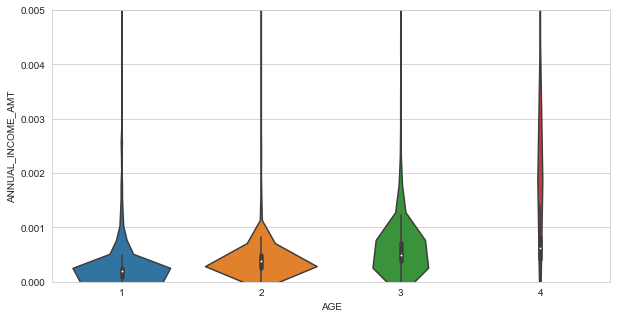

In [160]:
# 年齡越高收入越高
plt.figure(figsize=[10, 5])
sns.violinplot(x="AGE", y="ANNUAL_INCOME_AMT", data=train)
plt.ylim([0, 0.005])

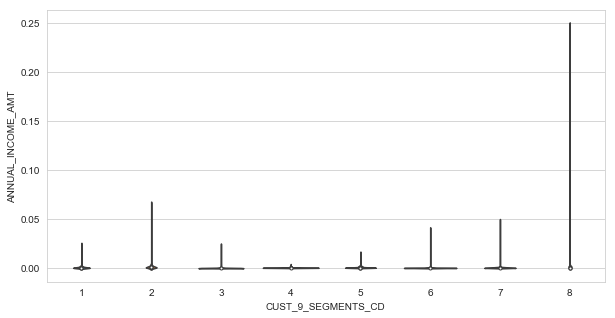

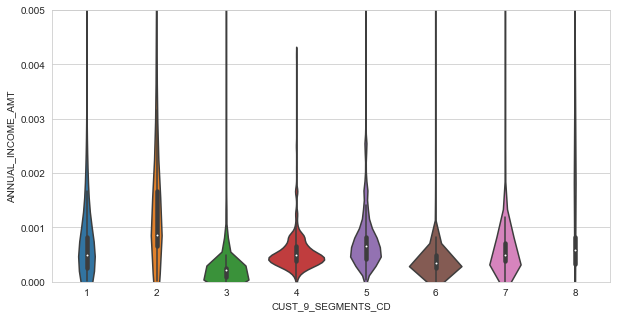

In [166]:
# 不同客群在收入方面有很大不同
plt.figure(figsize=[10, 5])
sns.violinplot(x="CUST_9_SEGMENTS_CD", y="ANNUAL_INCOME_AMT", data=train)
plt.show()
plt.figure(figsize=[10, 5])
sns.violinplot(x="CUST_9_SEGMENTS_CD", y="ANNUAL_INCOME_AMT", data=train)
plt.ylim([0, 0.005])
plt.show()

# 處理:
觀察多次實驗，取最穩定的前5重要性欄位來做模型
    1. AGE 
    2. CUST_9_SEGMENTS_CD 
    3. L1YR_GROSS_PRE_AMT 
    4. AG_CNT 
    5. LIFE_INSD_CNT

In [689]:
important_cols = ["AGE", "CUST_9_SEGMENTS_CD", "L1YR_GROSS_PRE_AMT", "AG_CNT", "LIFE_INSD_CNT"]
impute(important_cols=important_cols, impute_col="ANNUAL_INCOME_AMT", algorithm=ExtraTreesRegressor(random_state=111))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
          oob_score=False, random_state=111, verbose=0, warm_start=False)

In [690]:
# check
train["ANNUAL_INCOME_AMT"].count()

100000

In [691]:
# 有遺失值欄位個數
len(train.columns[pd.isnull(train).sum() != 0])

47

# L1YR_C_CNT(近一年到 C 通路申辦服務次數 ) 
* 遺失值數量:5637
* 由於數量不多，對Y的重要性沒有很顯著，推測母體應為常態分配，故暫時採用平均值填入(排除離群值後之平均)(以15次以內(含)為準)

In [692]:
sum(train["L1YR_C_CNT"].isnull())

5637

In [693]:
des_l1yr = train["L1YR_C_CNT"].describe()
print(des_l1yr)

count    94363.000000
mean         0.254983
std          1.088951
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         41.000000
Name: L1YR_C_CNT, dtype: float64


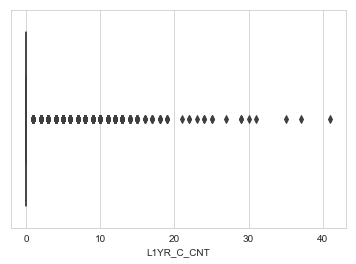

In [694]:
sns.boxplot("L1YR_C_CNT", data=train)

In [173]:
train["L1YR_C_CNT"].value_counts()

0.0     82299
1.0      7793
2.0      2282
3.0       780
4.0       338
5.0       179
12.0      143
6.0       106
7.0        86
11.0       81
8.0        65
10.0       52
9.0        49
13.0       48
15.0       15
14.0       13
18.0        5
17.0        5
19.0        4
16.0        4
22.0        2
25.0        2
29.0        2
24.0        2
21.0        1
27.0        1
41.0        1
35.0        1
37.0        1
31.0        1
23.0        1
30.0        1
Name: L1YR_C_CNT, dtype: int64

<module 'matplotlib.pyplot' from 'C:\\Users\\user\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

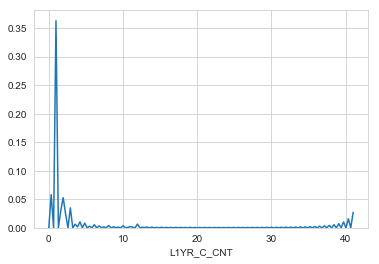

In [181]:
sns.distplot(train["L1YR_C_CNT"], kde=True, hist=False)

(0, 10)

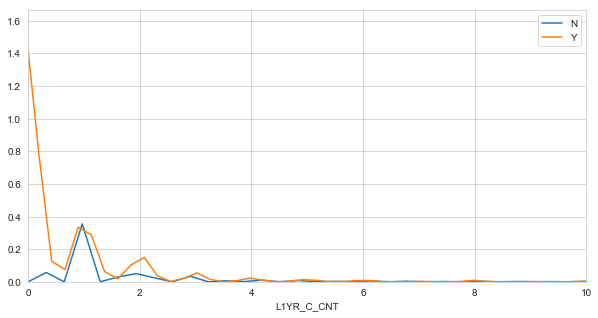

In [185]:
plt.figure(figsize=[10, 5])
sns.distplot(train[train["Y1"] == 0]["L1YR_C_CNT"], kde=True, hist=False, label="N")
sns.distplot(train[train["Y1"] == 1]["L1YR_C_CNT"], kde=True, hist=False, label="Y")
plt.xlim([0, 10])

In [695]:
# 共94329筆平均補值(取四捨五入至整數) => 0
round(train[train["L1YR_C_CNT"] <= 15]["L1YR_C_CNT"].mean(), 0)

0.0

In [696]:
# 補入
train["L1YR_C_CNT"].fillna(0, inplace=True)

In [697]:
# 有遺失值欄位個數
len(train.columns[pd.isnull(train).sum() != 0])

46

# BMI:根據EDA結論做離散化
是否在[0, 0.2)之間，NAN視為否

是:1;否:0
注意:此欄位從Numerical 轉成 nominal了

In [698]:
def bmi_impute(col):
    
    if pd.isnull(col):
        return 0
    
    elif col < 0.2 and col >= 0:
        return 1
    
    else:
        return 0
    

In [699]:
train["BMI"] = train["BMI"].apply(bmi_impute)

In [700]:
# 有遺失值欄位個數
len(train.columns[pd.isnull(train).sum() != 0])

45

# X_*_IND系列(A,B,...,H)
* 共38個遺失值(每一個欄位是同樣幾筆)
* 最後階段時刪除(Y在遺失值是少數、遺失值數量少影響不大)
* 暫不去探討這38筆資料的意義(重大性不大)

In [701]:
len(train[(train["X_A_IND"].isnull()) & (train["X_B_IND"].isnull()) 
      & (train["X_C_IND"].isnull()) & (train["X_D_IND"].isnull()) 
      & (train["X_E_IND"].isnull()) & (train["X_F_IND"].isnull())
      & (train["X_G_IND"].isnull()) & (train["X_H_IND"].isnull())])

38

In [702]:
train[train["X_A_IND"].isnull()]["Y1"].value_counts()

0    37
1     1
Name: Y1, dtype: int64

In [594]:
train[train["X_A_IND"].isnull()].info(max_cols=150)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 1706736 to 2399031
Data columns (total 116 columns):
GENDER                       38 non-null float64
AGE                          38 non-null int64
CHARGE_CITY_CD               38 non-null int64
CONTACT_CITY_CD              38 non-null int64
EDUCATION_CD                 38 non-null float64
MARRIAGE_CD                  38 non-null float64
LAST_A_CCONTACT_DT           38 non-null int64
L1YR_A_ISSUE_CNT             38 non-null int64
LAST_A_ISSUE_DT              38 non-null int64
L1YR_B_ISSUE_CNT             38 non-null int64
LAST_B_ISSUE_DT              38 non-null int64
CHANNEL_A_POL_CNT            38 non-null int64
CHANNEL_B_POL_CNT            38 non-null int64
OCCUPATION_CLASS_CD          38 non-null float64
APC_CNT                      38 non-null int64
INSD_CNT                     38 non-null int64
APC_1ST_AGE                  38 non-null float64
INSD_1ST_AGE                 38 non-null float64
IF_2ND_GEN_IND             

# 當年度保障相關欄位(共15欄)
* 各欄位的遺失值皆為27540筆，且完全是相同的某幾筆資料
* 和是不是被保人或要保人沒有完全直接關係
* 這部分的遺失值就算有意義基本上也不會是None，因為原則上保障(保額)就是有(>0)或沒有(=0)的概念，除非神秘轉換時不符數學邏輯，或是有些情況未被定義(ex.保障在今年中結束)。(基本上此欄位訊息沒有無法取得資料的可能)


In [595]:
100000 - 72460

27540

In [596]:
len(train[(train["DIEBENEFIT_AMT"].isnull()) & (train["DIEACCIDENT_AMT"].isnull()) 
          & (train["POLICY_VALUE_AMT"].isnull()) & (train["ANNUITY_AMT"].isnull()) 
          & (train["EXPIRATION_AMT"].isnull()) & (train["ACCIDENT_HOSPITAL_REC_AMT"].isnull())
          & (train["DISEASES_HOSPITAL_REC_AMT"].isnull()) & (train["OUTPATIENT_SURGERY_AMT"].isnull())
          & (train["INPATIENT_SURGERY_AMT"].isnull()) & (train["ILL_ACCELERATION_AMT"].isnull())
          & (train["FIRST_CANCER_AMT"].isnull()) & (train["ILL_ADDITIONAL_AMT"].isnull())
          & (train["LONG_TERM_CARE_AMT"].isnull()) & (train["MONTHLY_CARE_AMT"].isnull()) 
          & (train["PAY_LIMIT_MED_MISC_AMT"].isnull())])

27540

In [703]:
# 觀察非要保人、非被保人情況
amt_exper = pd.DataFrame(train_copy[["CUS_ID", "APC_1ST_AGE", "DIEBENEFIT_AMT", 
                                     "DIEACCIDENT_AMT", "POLICY_VALUE_AMT", "ANNUITY_AMT",
                                     "EXPIRATION_AMT", "ACCIDENT_HOSPITAL_REC_AMT", "DISEASES_HOSPITAL_REC_AMT", 
                                     "OUTPATIENT_SURGERY_AMT", "INPATIENT_SURGERY_AMT", "ILL_ACCELERATION_AMT", 
                                     "FIRST_CANCER_AMT", "ILL_ADDITIONAL_AMT", "LONG_TERM_CARE_AMT", 
                                     "MONTHLY_CARE_AMT", "PAY_LIMIT_MED_MISC_AMT", "IF_ADD_INSD_IND"]],
                        columns=["CUS_ID", "APC_1ST_AGE", "DIEBENEFIT_AMT", 
                                     "DIEACCIDENT_AMT", "POLICY_VALUE_AMT", "ANNUITY_AMT",
                                     "EXPIRATION_AMT", "ACCIDENT_HOSPITAL_REC_AMT", "DISEASES_HOSPITAL_REC_AMT", 
                                     "OUTPATIENT_SURGERY_AMT", "INPATIENT_SURGERY_AMT", "ILL_ACCELERATION_AMT", 
                                     "FIRST_CANCER_AMT", "ILL_ADDITIONAL_AMT", "LONG_TERM_CARE_AMT", 
                                     "MONTHLY_CARE_AMT", "PAY_LIMIT_MED_MISC_AMT", "IF_ADD_INSD_IND"])


amt_exper.set_index("CUS_ID", inplace=True)

In [704]:
# 非要保人(為被保人)
print("ap為遺失值，amt不是:", sum(amt_exper[pd.isnull(amt_exper["APC_1ST_AGE"])]["DIEBENEFIT_AMT"].value_counts()))
print("amt為遺失值，但ap不是:", sum(amt_exper[pd.isnull(amt_exper["DIEBENEFIT_AMT"])]["APC_1ST_AGE"].value_counts()))

ap為遺失值，amt不是: 31725
amt為遺失值，但ap不是: 15983


In [705]:
# 非被保人(為要保人)
print("ifad為遺失值，amt不是:", sum(amt_exper[pd.isnull(amt_exper["IF_ADD_INSD_IND"])]["DIEBENEFIT_AMT"].value_counts()))
print("amt為遺失值，但ifad不是:", sum(amt_exper[pd.isnull(amt_exper["DIEBENEFIT_AMT"])]["IF_ADD_INSD_IND"].value_counts()))

ifad為遺失值，amt不是: 5
amt為遺失值，但ifad不是: 27374


In [706]:
amt_list = ["DIEBENEFIT_AMT", "DIEACCIDENT_AMT", "POLICY_VALUE_AMT", "ANNUITY_AMT", 
            "EXPIRATION_AMT", "ACCIDENT_HOSPITAL_REC_AMT", "DISEASES_HOSPITAL_REC_AMT", 
            "OUTPATIENT_SURGERY_AMT", "INPATIENT_SURGERY_AMT", "ILL_ACCELERATION_AMT", 
            "FIRST_CANCER_AMT", "ILL_ADDITIONAL_AMT", "LONG_TERM_CARE_AMT", 
            "MONTHLY_CARE_AMT", "PAY_LIMIT_MED_MISC_AMT"]

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-0.1, 0.5)

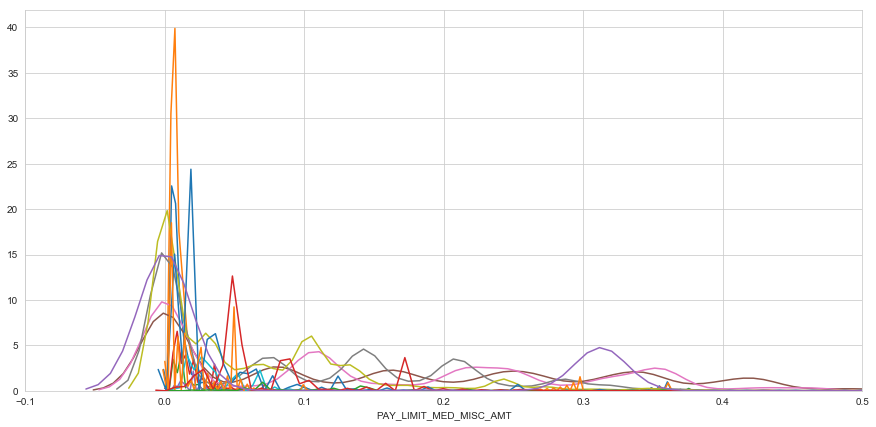

In [601]:
plt.figure(figsize=[15, 7])

for col in amt_list:
    sns.distplot(train[col].dropna(), kde=True, hist=False)
    
plt.xlim([-0.1, 0.5])

In [602]:

for col in amt_list:
    print(train[col].describe())
    print("-----------------------")
    

count    72460.000000
mean         0.003079
std          0.005977
min          0.000000
25%          0.000147
50%          0.001133
75%          0.003638
max          0.362252
Name: DIEBENEFIT_AMT, dtype: float64
-----------------------
count    72460.000000
mean         0.004402
std          0.007035
min          0.000000
25%          0.000260
50%          0.002437
75%          0.005787
max          0.362252
Name: DIEACCIDENT_AMT, dtype: float64
-----------------------
count    72460.000000
mean         0.000868
std          0.005358
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.378532
Name: POLICY_VALUE_AMT, dtype: float64
-----------------------
count    72460.000000
mean         0.002359
std          0.009075
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000214
max          0.377345
Name: ANNUITY_AMT, dtype: float64
-----------------------
count    72460.000000
mean         0.000321
std     

In [603]:
train[pd.isnull(train["DIEBENEFIT_AMT"])]["INSD_LAST_YEARDIF_CNT"].value_counts()

0.184210    2977
0.210526    2319
0.289474    2209
0.157895    2136
0.236842    1763
0.263158    1687
0.131579    1627
0.026316    1360
0.000000    1304
0.105263    1297
0.078947    1177
0.052632    1113
0.315790     919
0.473684     693
0.500000     516
0.526316     449
0.368421     435
0.421053     417
0.447368     390
0.578947     320
0.342105     320
0.552632     311
0.605263     280
0.394737     255
0.184211     189
0.157895     121
0.631579     111
0.210526      94
0.657895      66
0.131579      60
0.052632      58
0.026316      58
0.078947      58
0.105263      51
0.236842      36
0.263158      31
0.684210      22
0.710526      21
0.736842      20
0.289474      16
0.763158      16
0.368421      12
0.473684       9
0.315789       7
0.842105       6
0.394737       5
0.789474       5
0.342105       5
0.447368       4
0.894737       4
0.526316       4
0.921053       3
0.868421       2
0.552632       2
0.815790       2
0.421053       1
1.000000       1
Name: INSD_LAST_YEARDIF_CNT, dt

## 和下一部份IF_ISSUE_INSD_*_IND系列觀察

In [604]:
print("IF_ISSUE為遺失值，amt不是:", sum(train[pd.isnull(train["IF_ISSUE_INSD_A_IND"])]["DIEBENEFIT_AMT"].value_counts()))
print("amt為遺失值，但IF_ISSUE不是:", sum(train[pd.isnull(train["DIEBENEFIT_AMT"])]["IF_ISSUE_INSD_A_IND"].value_counts()))

IF_ISSUE為遺失值，amt不是: 1131
amt為遺失值，但IF_ISSUE不是: 8588


## 處理:觀察重要欄位

In [256]:
importance_measure("DIEBENEFIT_AMT", max_test=10, algorithm=ExtraTreesRegressor(random_state=111))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


重要性排序: ['LIFE_INSD_CNT' 'L1YR_GROSS_PRE_AMT' 'AGE' 'CUST_9_SEGMENTS_CD'
 'IF_ISSUE_C_IND' 'CONTACT_CITY_CD' 'TOOL_VISIT_1YEAR_CNT'
 'IF_2ND_GEN_IND' 'APC_CNT' 'AG_CNT' 'CHANNEL_A_POL_CNT' 'LAST_C_DT'
 'IM_CNT' 'BANK_NUMBER_CNT' 'AG_NOW_CNT' 'IF_HOUSEHOLD_CLAIM_IND'
 'IF_Y_REAL_IND' 'CHARGE_CITY_CD' 'IF_S_REAL_IND' 'IF_ISSUE_Q_IND'
 'INSD_CNT' 'IM_IS_D_IND' 'LIFE_CNT' 'IF_ADD_R_IND' 'IM_IS_B_IND'
 'IF_ISSUE_P_IND' 'IM_IS_C_IND' 'LAST_A_CCONTACT_DT' 'CLC_CUR_NUM'
 'LAST_A_ISSUE_DT' 'IF_ISSUE_N_IND' 'LAST_B_CONTACT_DT' 'IF_ADD_F_IND'
 'IF_ADD_Q_IND' 'IF_ISSUE_I_IND' 'IF_ISSUE_A_IND' 'IF_ADD_L_IND'
 'L1YR_PAYMENT_REMINDER_IND' 'IF_ISSUE_D_IND' 'IF_ISSUE_J_IND'
 'L1YR_A_ISSUE_CNT' 'IF_ISSUE_M_IND' 'IF_ISSUE_B_IND' 'IF_ADD_IND'
 'L1YR_LAPSE_IND' 'IF_ISSUE_G_IND' 'IF_ISSUE_O_IND' 'IF_ISSUE_F_IND'
 'IM_IS_A_IND' 'CHANNEL_B_POL_CNT' 'IF_ISSUE_L_IND' 'IF_ADD_G_IND'
 'IF_ISSUE_K_IND' 'IF_ISSUE_E_IND' 'LAST_B_ISSUE_DT' 'L1YR_B_ISSUE_CNT'
 'IF_ISSUE_H_IND']
-----------------------------------
測試欄位數

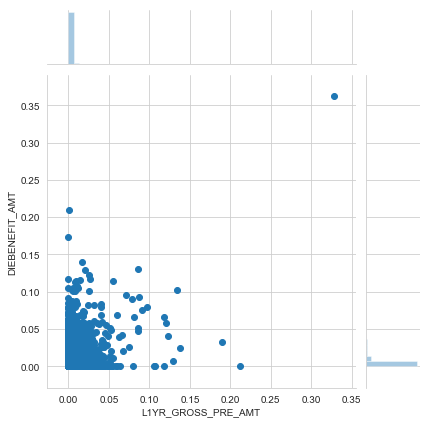

In [359]:
# L1YR_GROSS_PRE_AMT近一年實繳保費=>原則上會非常相關，保費繳越多保障越多，只是變成不同類別的保障括分這部分
# 觀察這些欄位和Y的關係=>可能可以考慮合併(累加)，再用此欄位衡量遺失值
sns.jointplot(x="L1YR_GROSS_PRE_AMT", y=amt_list[0], data=train)

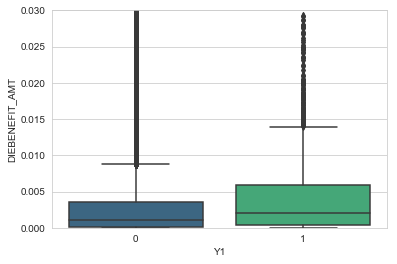

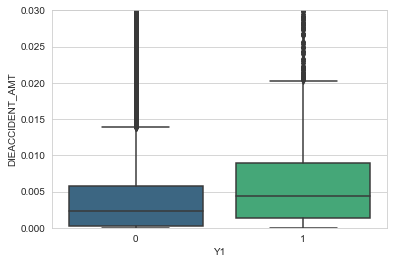

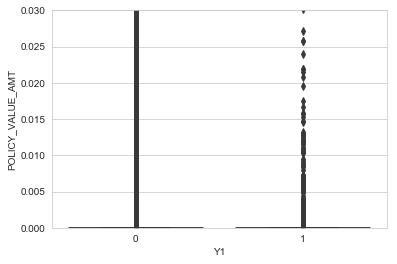

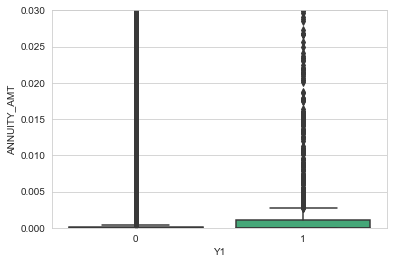

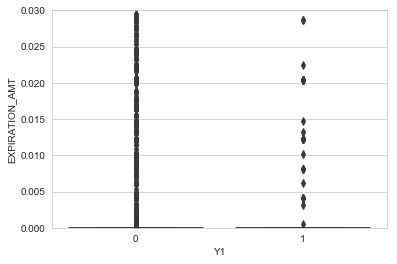

In [325]:
# 和Y的關聯
for i in amt_list[:5]:
    sns.boxplot(x="Y1", y=i, data=train, palette="viridis")
    plt.ylim([0, 0.03])
    plt.show()
    


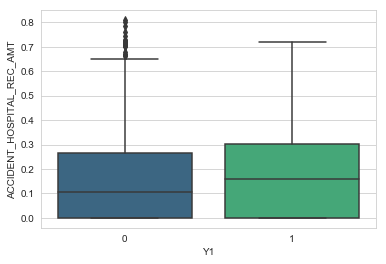

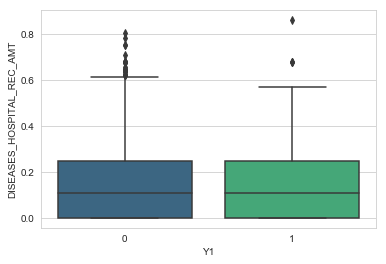

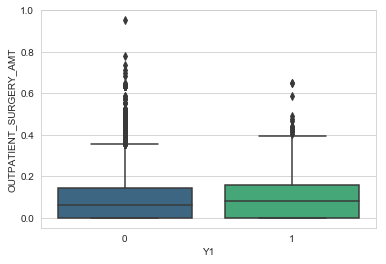

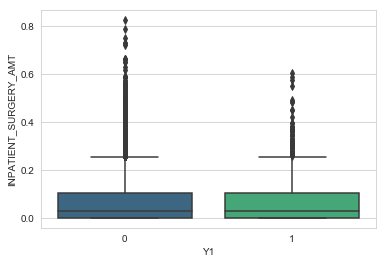

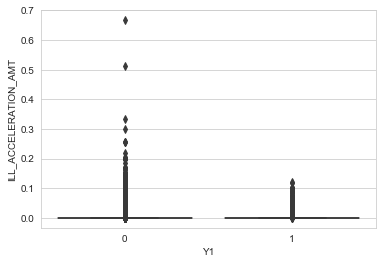

In [327]:
for i in amt_list[5:10]:
    sns.boxplot(x="Y1", y=i, data=train, palette="viridis")
    plt.show()

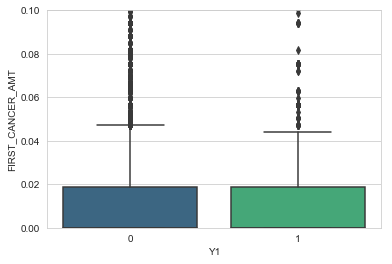

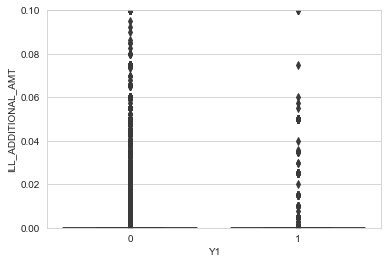

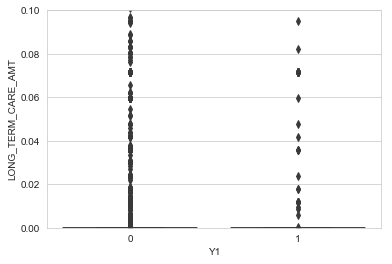

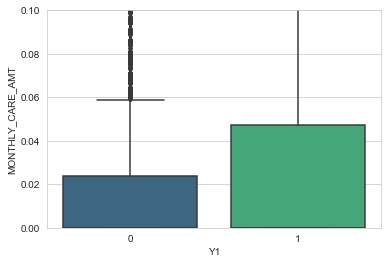

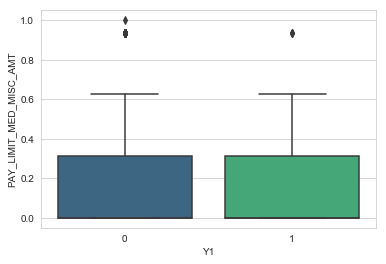

In [331]:
for i in amt_list[10:14]:
    sns.boxplot(x="Y1", y=i, data=train, palette="viridis")
    plt.ylim([0, 0.1])
    plt.show()
    
sns.boxplot(x="Y1", y=amt_list[14], data=train, palette="viridis")
plt.show()

In [337]:
# 觀察在amt_list內第2 4 9 11 12 index
for i in [2, 4, 9, 11, 12]:
    print(train[amt_list[i]].value_counts().head())


0.000000    61862
0.000153       16
0.001246        7
0.000015        6
0.000014        5
Name: POLICY_VALUE_AMT, dtype: int64
0.000000    71299
0.020442      207
0.012265      205
0.008177      125
0.004088       67
Name: EXPIRATION_AMT, dtype: int64
0.000000    62890
0.033333     1043
0.025641     1041
0.066667      802
0.020000      796
Name: ILL_ACCELERATION_AMT, dtype: int64
0.000    65383
0.005     2161
0.050     1213
0.025     1138
0.015      928
Name: ILL_ADDITIONAL_AMT, dtype: int64
0.000000    70778
0.071429      349
0.142857      323
0.011905      185
0.119048      126
Name: LONG_TERM_CARE_AMT, dtype: int64


## 此系列欄位與Y關係
1. 有購買重疾險較多DIEBENEFIT_AMT、DIEACCIDENT_AMT、ANNUITY_AMT、ACCIDENT_HOSPITAL_REC_AMT、OUTPATIENT_SURGERY_AMT、MONTHLY_CARE_AMT(0 1 3 5 7 13)
2. 沒購買重疾險較多DISEASES_HOSPITAL_REC_AMT、FIRST_CANCER_AMT(6 10)
3. 無顯著差異:INPATIENT_SURGERY_AMT、PAY_LIMIT_MED_MISC_AMT、POLICY_VALUE_AMT、EXPIRATION_AMT、ILL_ACCELERATION_AMT、ILL_ADDITIONAL_AMT、LONG_TERM_CARE_AMT(8 14 2 4 9 11 12)

In [707]:
# 和y的關係大多同向可考慮加成後看結果
train["TOTAL_AMT"] = (train["DIEBENEFIT_AMT"] + train["DIEACCIDENT_AMT"] + train["ANNUITY_AMT"] + train["ACCIDENT_HOSPITAL_REC_AMT"]
                      + train["OUTPATIENT_SURGERY_AMT"] + train["MONTHLY_CARE_AMT"] + train["DISEASES_HOSPITAL_REC_AMT"] + train["FIRST_CANCER_AMT"]
                      + train["INPATIENT_SURGERY_AMT"] + train["PAY_LIMIT_MED_MISC_AMT"] + train["POLICY_VALUE_AMT"] + train["EXPIRATION_AMT"]
                      + train["ILL_ACCELERATION_AMT"] + train["ILL_ADDITIONAL_AMT"] + train["LONG_TERM_CARE_AMT"])

In [708]:
# chceck
sum(train["TOTAL_AMT"].isnull())

27540

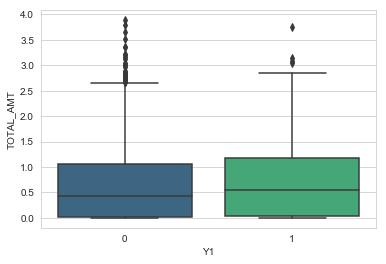

In [709]:
sns.boxplot(x="Y1", y="TOTAL_AMT", data=train, palette="viridis")

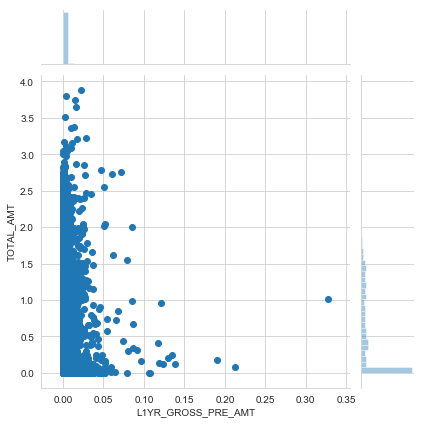

In [608]:
sns.jointplot(x="L1YR_GROSS_PRE_AMT", y="TOTAL_AMT", data=train)

In [343]:
important_test("TOTAL_AMT", algorithm=ExtraTreesRegressor(random_state=111))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[('AGE', 10), ('IF_Y_REAL_IND', 10), ('TOOL_VISIT_1YEAR_CNT', 10), ('IF_2ND_GEN_IND', 10), ('IF_S_REAL_IND', 10), ('IF_ADD_Q_IND', 10), ('APC_CNT', 10), ('LIFE_INSD_CNT', 10), ('CONTACT_CITY_CD', 10), ('IF_ISSUE_Q_IND', 4), ('CUST_9_SEGMENTS_CD', 3), ('INSD_CNT', 3)]


([('AGE', 10),
  ('IF_Y_REAL_IND', 10),
  ('TOOL_VISIT_1YEAR_CNT', 10),
  ('IF_2ND_GEN_IND', 10),
  ('IF_S_REAL_IND', 10),
  ('IF_ADD_Q_IND', 10),
  ('APC_CNT', 10),
  ('LIFE_INSD_CNT', 10),
  ('CONTACT_CITY_CD', 10),
  ('IF_ISSUE_Q_IND', 4),
  ('CUST_9_SEGMENTS_CD', 3),
  ('INSD_CNT', 3)],
 [3159, 8102, 4836, 307, 9315, 3503, 603, 9690, 9256, 365])

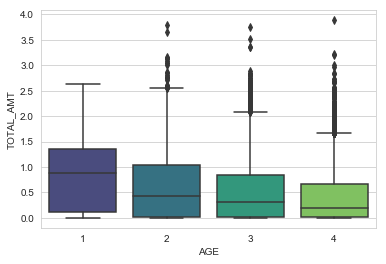

In [609]:
sns.boxplot(x="AGE", y="TOTAL_AMT", data=train, palette="viridis")

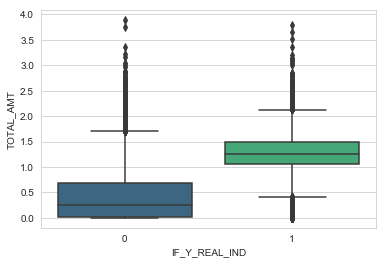

In [610]:
sns.boxplot(x="IF_Y_REAL_IND", y="TOTAL_AMT", data=train, palette="viridis")

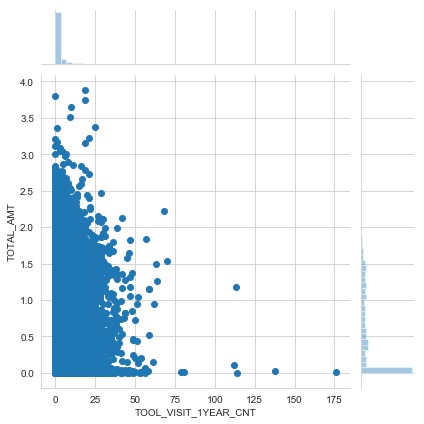

In [611]:
sns.jointplot(x="TOOL_VISIT_1YEAR_CNT", y="TOTAL_AMT", data=train)

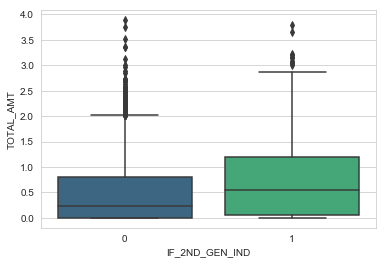

In [612]:
sns.boxplot(x="IF_2ND_GEN_IND", y="TOTAL_AMT", data=train, palette="viridis")

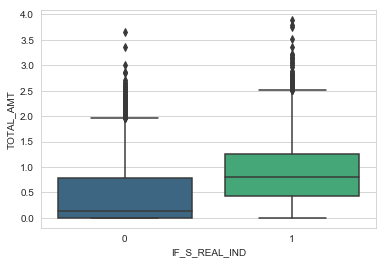

In [613]:
sns.boxplot(x="IF_S_REAL_IND", y="TOTAL_AMT", data=train, palette="viridis")

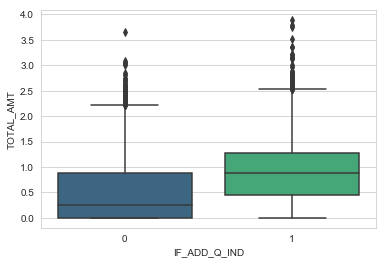

In [614]:
sns.boxplot(x="IF_ADD_Q_IND", y="TOTAL_AMT", data=train, palette="viridis")

### 由於加成起來後解釋上變得很方便，但有遺失訊息的疑慮，這裡先暫時這麼做，把原本的欄位刪除，用重要性較穩定的9項目來預估加成後的遺失值
### Note:加成後欄位TOTAL_AMT:總當年度保障

In [710]:
important_cols = ["AGE", "IF_Y_REAL_IND", "TOOL_VISIT_1YEAR_CNT", "IF_2ND_GEN_IND", "IF_S_REAL_IND", 
                  "IF_ADD_Q_IND", "APC_CNT", "LIFE_INSD_CNT", "CONTACT_CITY_CD"]
impute(important_cols=important_cols, impute_col="TOTAL_AMT", algorithm=ExtraTreesRegressor(random_state=111))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
          oob_score=False, random_state=111, verbose=0, warm_start=False)

In [711]:
# check
sum(train["TOTAL_AMT"].isnull())

0

In [712]:
# del original col
train.drop(amt_list, axis=1, inplace=True)

In [713]:
# 有遺失值欄位個數
len(train.columns[pd.isnull(train).sum() != 0])

30

# IF_ISSUE_INSD_*_IND系列 (A,B,...,Q)(共17欄位)
* 共20083筆遺失值，各欄位都是同幾筆資料遺失
1. 其中171應為非被保險人(這部分不用理會=>因之後會直接刪掉這171個資料)
2. 剩餘19912為其他原因

其他發現:

* LIFE_INSD_CNT目前主約被保有效件數(件)(神秘轉換&歸一化) 若為0 則此系列欄位為遺失值。也就是說在後面系列是缺值的，在此都被顯示成0，代表神秘轉換至少對於NAN是將其處理成0



In [619]:
train["LIFE_INSD_CNT"].value_counts()

0.015625    31604
0.000000    20083
0.031250    19635
0.046875    12396
0.062500     6773
0.078125     3671
0.093750     2110
0.109375     1317
0.125000      774
0.140625      470
0.156250      324
0.171875      221
0.187500      134
0.203125      118
0.218750       79
0.234375       69
0.250000       46
0.265625       41
0.281250       20
0.296875       20
0.343750       13
0.359375       11
0.328125       11
0.375000        9
0.312500        9
0.390625        6
0.437500        5
0.406250        5
0.453125        4
0.421875        4
0.562500        2
0.546875        2
0.625000        2
0.484375        2
0.500000        2
0.468750        2
0.531250        1
0.875000        1
0.515625        1
0.921875        1
0.734375        1
0.687500        1
Name: LIFE_INSD_CNT, dtype: int64

In [620]:
100000 - 79917

20083

In [621]:
len(train[(train["IF_ISSUE_INSD_A_IND"].isnull()) & (train["IF_ISSUE_INSD_J_IND"].isnull()) 
          & (train["IF_ISSUE_INSD_B_IND"].isnull()) & (train["IF_ISSUE_INSD_K_IND"].isnull()) 
          & (train["IF_ISSUE_INSD_C_IND"].isnull()) & (train["IF_ISSUE_INSD_L_IND"].isnull())
          & (train["IF_ISSUE_INSD_D_IND"].isnull()) & (train["IF_ISSUE_INSD_M_IND"].isnull())
          & (train["IF_ISSUE_INSD_E_IND"].isnull()) & (train["IF_ISSUE_INSD_N_IND"].isnull())
          & (train["IF_ISSUE_INSD_F_IND"].isnull()) & (train["IF_ISSUE_INSD_O_IND"].isnull())
          & (train["IF_ISSUE_INSD_G_IND"].isnull()) & (train["IF_ISSUE_INSD_P_IND"].isnull()) 
          & (train["IF_ISSUE_INSD_H_IND"].isnull()) & (train["IF_ISSUE_INSD_Q_IND"].isnull())
          & (train["IF_ISSUE_INSD_I_IND"].isnull())])

20083

In [714]:
# 171非被保險人此欄皆缺值
train[train["IF_ADD_INSD_IND"].isnull()]["IF_ISSUE_INSD_A_IND"].value_counts()

Series([], Name: IF_ISSUE_INSD_A_IND, dtype: int64)

In [623]:
# 大多都是極少數/少數類別在1
lst = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q"]
for i in lst:
    print(i)
    
    print(train["IF_ISSUE_{}_IND".format(i)].value_counts())
    print("----------------")

A
0    98123
1     1877
Name: IF_ISSUE_A_IND, dtype: int64
----------------
B
0    99021
1      979
Name: IF_ISSUE_B_IND, dtype: int64
----------------
C
0    96411
1     3589
Name: IF_ISSUE_C_IND, dtype: int64
----------------
D
0    92820
1     7180
Name: IF_ISSUE_D_IND, dtype: int64
----------------
E
0    99862
1      138
Name: IF_ISSUE_E_IND, dtype: int64
----------------
F
0    97101
1     2899
Name: IF_ISSUE_F_IND, dtype: int64
----------------
G
0    97325
1     2675
Name: IF_ISSUE_G_IND, dtype: int64
----------------
H
0    99966
1       34
Name: IF_ISSUE_H_IND, dtype: int64
----------------
I
0    94373
1     5627
Name: IF_ISSUE_I_IND, dtype: int64
----------------
J
0    89030
1    10970
Name: IF_ISSUE_J_IND, dtype: int64
----------------
K
0    99745
1      255
Name: IF_ISSUE_K_IND, dtype: int64
----------------
L
0    99466
1      534
Name: IF_ISSUE_L_IND, dtype: int64
----------------
M
0    99900
1      100
Name: IF_ISSUE_M_IND, dtype: int64
----------------
N
0    84878

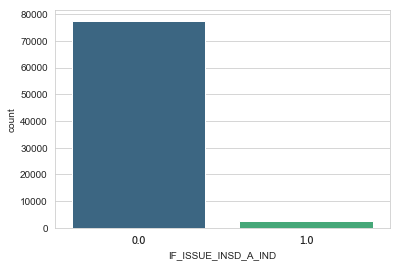

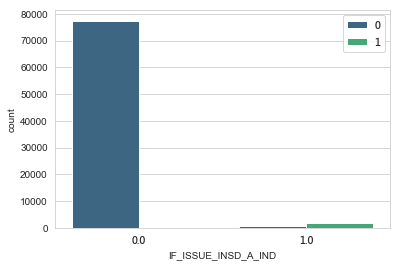

-------------------------------
0.0:
0    77455
1       92
Name: IF_ISSUE_A_IND, dtype: int64
0(%): 99.88136227062297
1(%): 0.11863772937702297
-------------------------------
nan:
0    20068
1       15
Name: IF_ISSUE_A_IND, dtype: int64
0(%): 99.92530996365085
1(%): 0.07469003634915101
-------------------------------
1.0:
1    1770
0     600
Name: IF_ISSUE_A_IND, dtype: int64
0(%): 25.31645569620253
1(%): 74.68354430379746


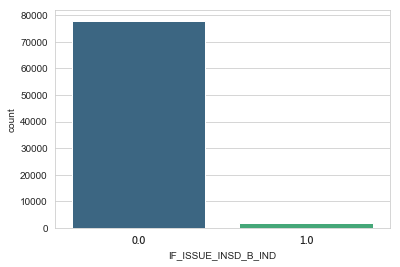

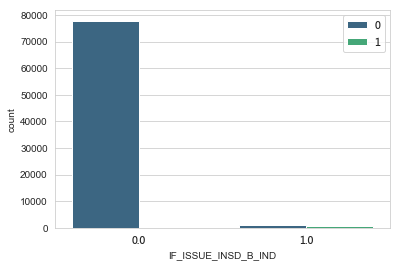

-------------------------------
0.0:
0    77839
1      110
Name: IF_ISSUE_B_IND, dtype: int64
0(%): 99.85888208957138
1(%): 0.14111791042861357
-------------------------------
nan:
0    20069
1       14
Name: IF_ISSUE_B_IND, dtype: int64
0(%): 99.93028929940746
1(%): 0.06971070059254096
-------------------------------
1.0:
0    1113
1     855
Name: IF_ISSUE_B_IND, dtype: int64
0(%): 56.55487804878049
1(%): 43.44512195121951


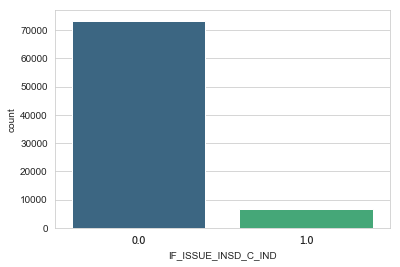

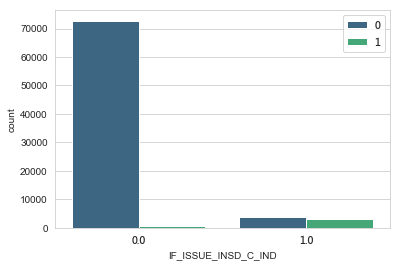

-------------------------------
0.0:
0    72735
1      562
Name: IF_ISSUE_C_IND, dtype: int64
0(%): 99.23325647707273
1(%): 0.7667435229272686
-------------------------------
nan:
0    19998
1       85
Name: IF_ISSUE_C_IND, dtype: int64
0(%): 99.57675646068815
1(%): 0.4232435393118558
-------------------------------
1.0:
0    3678
1    2942
Name: IF_ISSUE_C_IND, dtype: int64
0(%): 55.55891238670695
1(%): 44.44108761329305


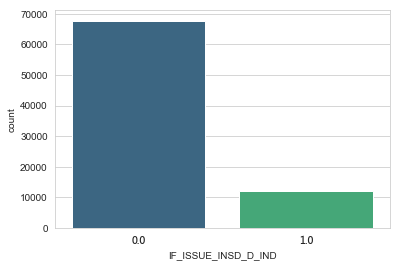

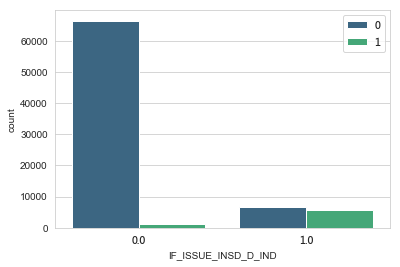

-------------------------------
0.0:
0    66451
1     1302
Name: IF_ISSUE_D_IND, dtype: int64
0(%): 98.07831387540034
1(%): 1.9216861245996488
-------------------------------
nan:
0    19837
1      246
Name: IF_ISSUE_D_IND, dtype: int64
0(%): 98.77508340387392
1(%): 1.2249165961260768
-------------------------------
1.0:
0    6532
1    5632
Name: IF_ISSUE_D_IND, dtype: int64
0(%): 53.69944097336402
1(%): 46.30055902663597


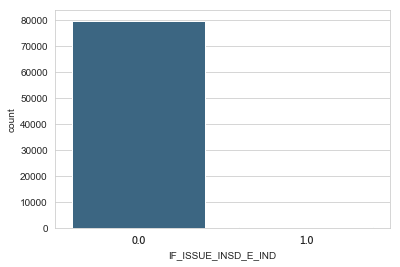

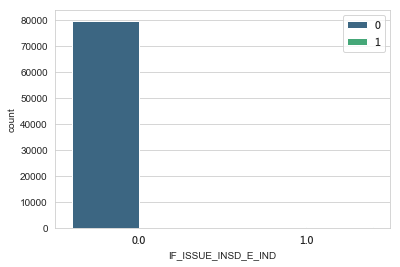

-------------------------------
0.0:
0    79755
1        2
Name: IF_ISSUE_E_IND, dtype: int64
0(%): 99.99749238311371
1(%): 0.002507616886292112
-------------------------------
nan:
0    20083
Name: IF_ISSUE_E_IND, dtype: int64
0(%): 100.0
-------------------------------
1.0:
1    136
0     24
Name: IF_ISSUE_E_IND, dtype: int64
0(%): 15.0
1(%): 85.0


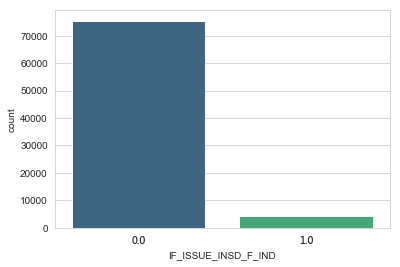

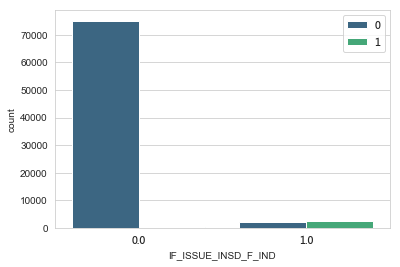

-------------------------------
0.0:
0    75133
1      334
Name: IF_ISSUE_F_IND, dtype: int64
0(%): 99.55742244954749
1(%): 0.4425775504525157
-------------------------------
1.0:
1    2510
0    1940
Name: IF_ISSUE_F_IND, dtype: int64
0(%): 43.59550561797752
1(%): 56.40449438202248
-------------------------------
nan:
0    20028
1       55
Name: IF_ISSUE_F_IND, dtype: int64
0(%): 99.72613653338644
1(%): 0.27386346661355376


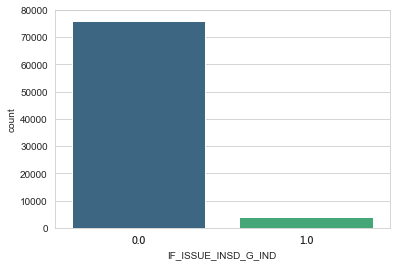

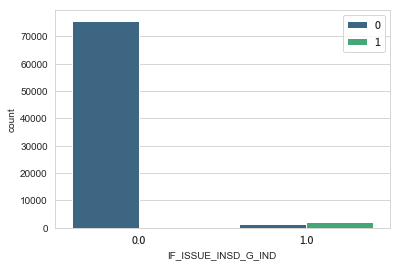

-------------------------------
0.0:
0    75739
1      339
Name: IF_ISSUE_G_IND, dtype: int64
0(%): 99.5544046899235
1(%): 0.44559531007650044
-------------------------------
nan:
0    20040
1       43
Name: IF_ISSUE_G_IND, dtype: int64
0(%): 99.78588856246576
1(%): 0.21411143753423292
-------------------------------
1.0:
1    2293
0    1546
Name: IF_ISSUE_G_IND, dtype: int64
0(%): 40.27090388121907
1(%): 59.72909611878093


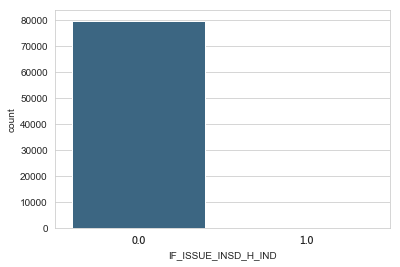

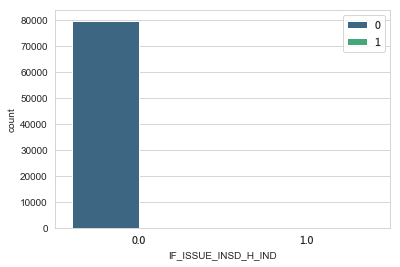

-------------------------------
0.0:
0    79883
Name: IF_ISSUE_H_IND, dtype: int64
0(%): 100.0
-------------------------------
nan:
0    20083
Name: IF_ISSUE_H_IND, dtype: int64
0(%): 100.0
-------------------------------
1.0:
1    34
Name: IF_ISSUE_H_IND, dtype: int64
1(%): 100.0


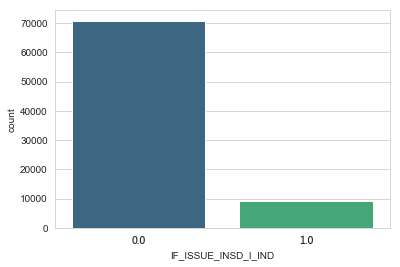

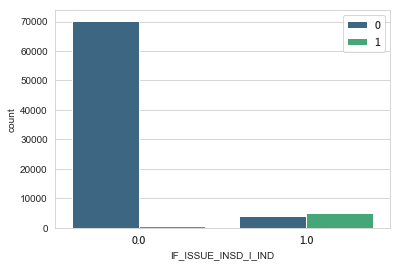

-------------------------------
0.0:
0    70281
1      526
Name: IF_ISSUE_I_IND, dtype: int64
0(%): 99.25713559393844
1(%): 0.7428644060615476
-------------------------------
1.0:
1    5025
0    4085
Name: IF_ISSUE_I_IND, dtype: int64
0(%): 44.840834248079034
1(%): 55.159165751920966
-------------------------------
nan:
0    20007
1       76
Name: IF_ISSUE_I_IND, dtype: int64
0(%): 99.62157048249763
1(%): 0.3784295175023652


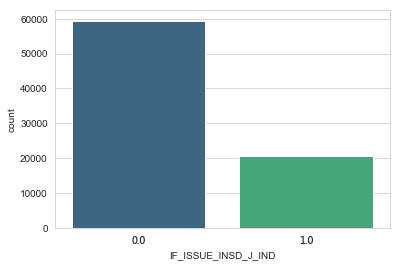

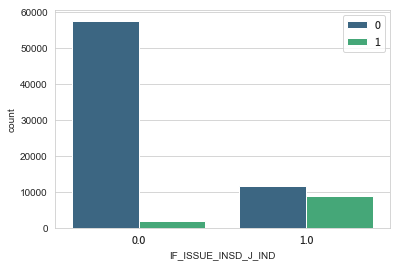

-------------------------------
0.0:
0    57613
1     1809
Name: IF_ISSUE_J_IND, dtype: int64
0(%): 96.95567298307024
1(%): 3.0443270169297567
-------------------------------
nan:
0    19689
1      394
Name: IF_ISSUE_J_IND, dtype: int64
0(%): 98.03814171189563
1(%): 1.9618582881043667
-------------------------------
1.0:
0    11728
1     8767
Name: IF_ISSUE_J_IND, dtype: int64
0(%): 57.22371310075628
1(%): 42.77628689924372


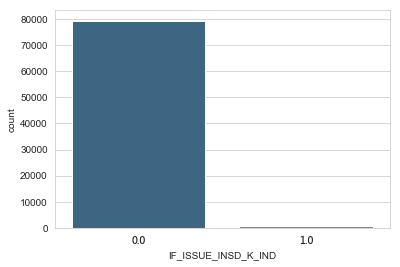

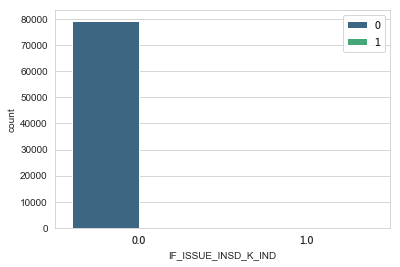

-------------------------------
0.0:
0    79346
1       39
Name: IF_ISSUE_K_IND, dtype: int64
0(%): 99.9508723310449
1(%): 0.04912766895509227
-------------------------------
nan:
0    20077
1        6
Name: IF_ISSUE_K_IND, dtype: int64
0(%): 99.97012398546033
1(%): 0.029876014539660413
-------------------------------
1.0:
0    322
1    210
Name: IF_ISSUE_K_IND, dtype: int64
0(%): 60.526315789473685
1(%): 39.473684210526315


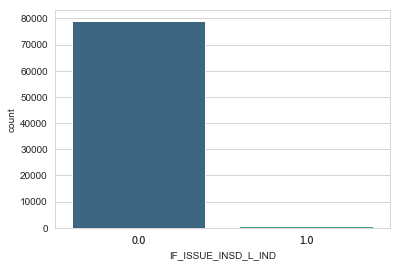

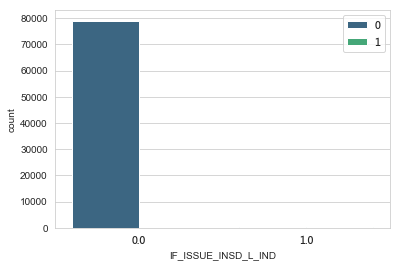

-------------------------------
0.0:
0    79037
1      109
Name: IF_ISSUE_L_IND, dtype: int64
0(%): 99.86227983726278
1(%): 0.13772016273721982
-------------------------------
nan:
0    20075
1        8
Name: IF_ISSUE_L_IND, dtype: int64
0(%): 99.96016531394713
1(%): 0.03983468605288054
-------------------------------
1.0:
1    417
0    354
Name: IF_ISSUE_L_IND, dtype: int64
0(%): 45.91439688715953
1(%): 54.08560311284047


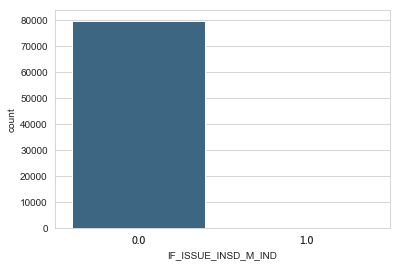

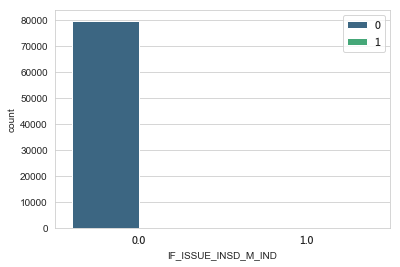

-------------------------------
0.0:
0    79744
1        8
Name: IF_ISSUE_M_IND, dtype: int64
0(%): 99.98996890360117
1(%): 0.010031096398836392
-------------------------------
nan:
0    20080
1        3
Name: IF_ISSUE_M_IND, dtype: int64
0(%): 99.98506199273017
1(%): 0.014938007269830206
-------------------------------
1.0:
1    89
0    76
Name: IF_ISSUE_M_IND, dtype: int64
0(%): 46.06060606060606
1(%): 53.939393939393945


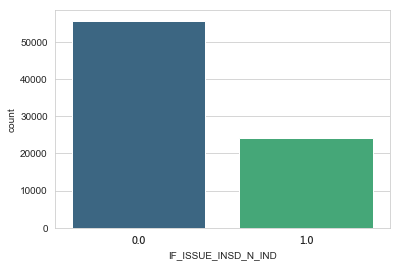

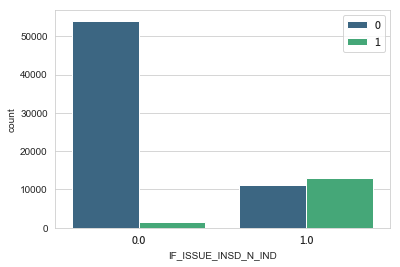

-------------------------------
1.0:
1    13102
0    11151
Name: IF_ISSUE_N_IND, dtype: int64
0(%): 45.97781717725642
1(%): 54.02218282274358
-------------------------------
0.0:
0    54045
1     1619
Name: IF_ISSUE_N_IND, dtype: int64
0(%): 97.09147743604484
1(%): 2.9085225639551595
-------------------------------
nan:
0    19682
1      401
Name: IF_ISSUE_N_IND, dtype: int64
0(%): 98.00328636159936
1(%): 1.9967136384006374


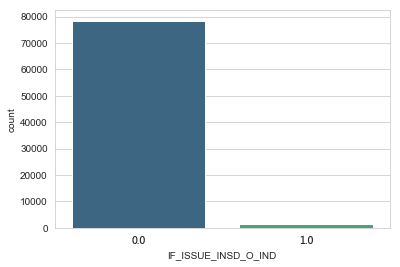

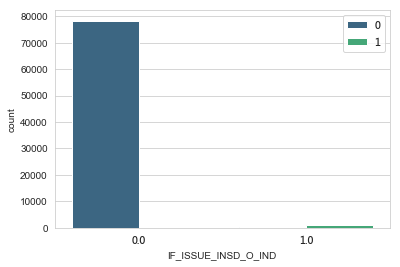

-------------------------------
0.0:
0    78312
1      100
Name: IF_ISSUE_O_IND, dtype: int64
0(%): 99.87246849971943
1(%): 0.12753150028056928
-------------------------------
nan:
0    20070
1       13
Name: IF_ISSUE_O_IND, dtype: int64
0(%): 99.93526863516406
1(%): 0.0647313648359309
-------------------------------
1.0:
1    1052
0     453
Name: IF_ISSUE_O_IND, dtype: int64
0(%): 30.09966777408638
1(%): 69.90033222591362


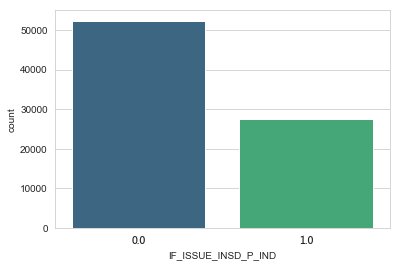

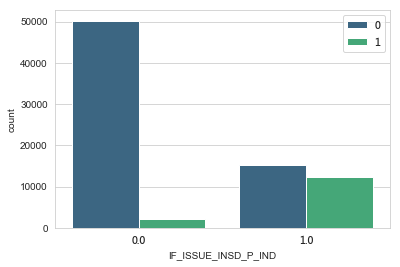

-------------------------------
0.0:
0    50225
1     2143
Name: IF_ISSUE_P_IND, dtype: int64
0(%): 95.90780629391995
1(%): 4.092193706080049
-------------------------------
1.0:
0    15148
1    12401
Name: IF_ISSUE_P_IND, dtype: int64
0(%): 54.985661911503136
1(%): 45.01433808849686
-------------------------------
nan:
0    19605
1      478
Name: IF_ISSUE_P_IND, dtype: int64
0(%): 97.6198775083404
1(%): 2.3801224916596126


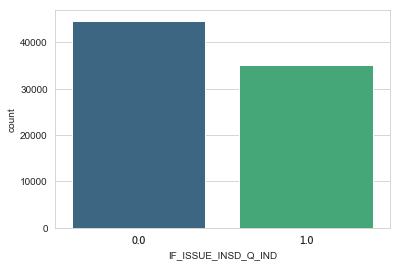

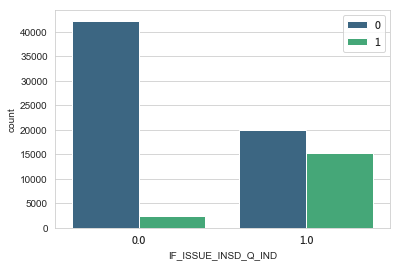

-------------------------------
0.0:
0    42269
1     2421
Name: IF_ISSUE_Q_IND, dtype: int64
0(%): 94.58268068919222
1(%): 5.417319310807787
-------------------------------
1.0:
0    19939
1    15288
Name: IF_ISSUE_Q_IND, dtype: int64
0(%): 56.60147046299713
1(%): 43.398529537002865
-------------------------------
nan:
0    19384
1      699
Name: IF_ISSUE_Q_IND, dtype: int64
0(%): 96.51944430612957
1(%): 3.480555693870438


In [624]:
for i in lst:
    count_and_percent("IF_ISSUE_INSD_{}_IND".format(i), train, "IF_ISSUE_{}_IND".format(i))

## 將資料分割成3種人
1. 純要保人(171) train_Applicant 
2. 純被保險人(43282)=>train_Insured 
3. 同時為要保人、被保險人(56547) => train_mix

mix中的12211遺失值以是否持有保單系列來填值，觀察後多呈現(持有,被保):(是,是)(否,否)狀態

純要保人中171遺失值不處理待刪除

純被保險人7701筆則須用其他方式 =>先用眾數

In [715]:
train_Applicant = train[train["IF_ADD_INSD_IND"].isnull()]
train_Insured = train[train["APC_1ST_AGE"] == 0]
train_mix = train.drop(pd.concat([train_Applicant, train_Insured]).index, axis=0)

In [716]:
print(train_Applicant.info())
print(train_Insured.info())
print(train_mix.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 1034973 to 1994377
Columns: 102 entries, GENDER to TOTAL_AMT
dtypes: float64(43), int64(59)
memory usage: 137.6 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43282 entries, 489 to 2512737
Columns: 102 entries, GENDER to TOTAL_AMT
dtypes: float64(43), int64(59)
memory usage: 34.0 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 56547 entries, 3418 to 2550614
Columns: 102 entries, GENDER to TOTAL_AMT
dtypes: float64(43), int64(59)
memory usage: 44.4 MB
None


In [717]:
print("Insured的遺失值:", 43282 - sum(train_Insured["IF_ISSUE_INSD_A_IND"].value_counts()))
print("mix的遺失值:", 56547 - sum(train_mix["IF_ISSUE_INSD_A_IND"].value_counts()))

Insured的遺失值: 7701
mix的遺失值: 12211


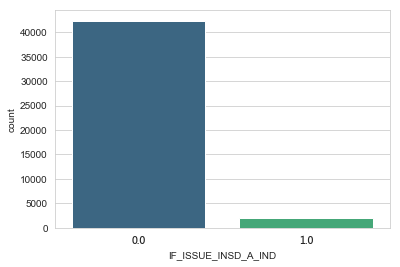

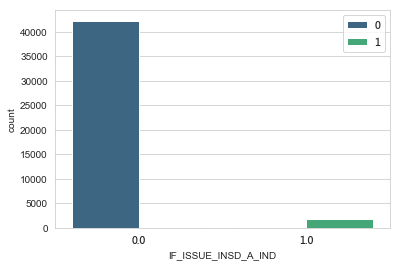

-------------------------------
0.0:
0    42272
1       92
Name: IF_ISSUE_A_IND, dtype: int64
0(%): 99.78283448210745
1(%): 0.21716551789255026
-------------------------------
nan:
0    12196
1       15
Name: IF_ISSUE_A_IND, dtype: int64
0(%): 99.87715993776104
1(%): 0.12284006223896486
-------------------------------
1.0:
1    1770
0     202
Name: IF_ISSUE_A_IND, dtype: int64
0(%): 10.243407707910752
1(%): 89.75659229208925


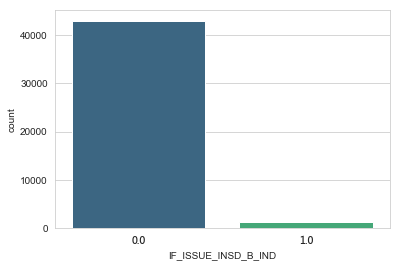

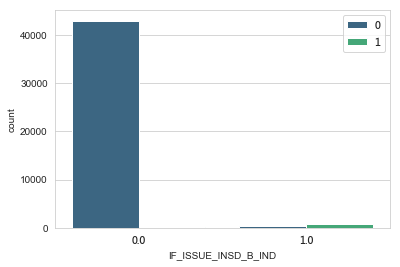

-------------------------------
0.0:
0    42929
1      110
Name: IF_ISSUE_B_IND, dtype: int64
0(%): 99.74441785357466
1(%): 0.25558214642533517
-------------------------------
nan:
0    12198
1       13
Name: IF_ISSUE_B_IND, dtype: int64
0(%): 99.89353861272623
1(%): 0.10646138727376955
-------------------------------
1.0:
1    855
0    442
Name: IF_ISSUE_B_IND, dtype: int64
0(%): 34.07864302235929
1(%): 65.92135697764071


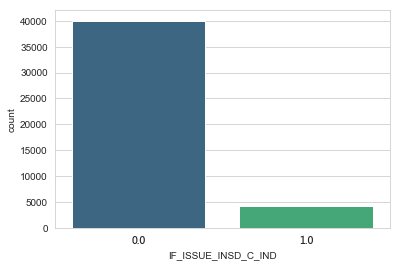

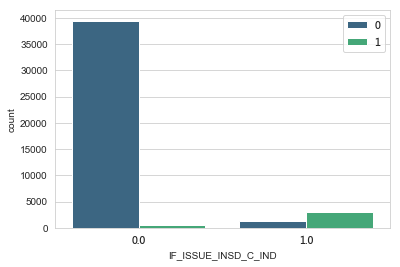

-------------------------------
0.0:
0    39466
1      562
Name: IF_ISSUE_C_IND, dtype: int64
0(%): 98.59598281203158
1(%): 1.4040171879684222
-------------------------------
nan:
0    12132
1       79
Name: IF_ISSUE_C_IND, dtype: int64
0(%): 99.35304233887479
1(%): 0.646957661125215
-------------------------------
1.0:
1    2942
0    1366
Name: IF_ISSUE_C_IND, dtype: int64
0(%): 31.708449396471682
1(%): 68.29155060352832


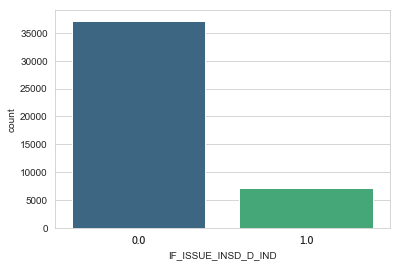

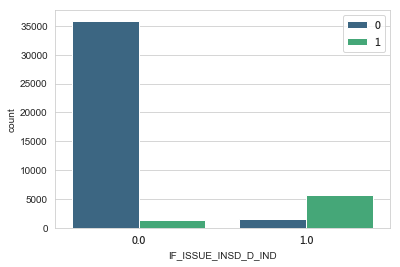

-------------------------------
0.0:
0    35901
1     1302
Name: IF_ISSUE_D_IND, dtype: int64
0(%): 96.5002822353036
1(%): 3.499717764696395
-------------------------------
nan:
0    11982
1      229
Name: IF_ISSUE_D_IND, dtype: int64
0(%): 98.12464171648514
1(%): 1.8753582835148634
-------------------------------
1.0:
1    5632
0    1501
Name: IF_ISSUE_D_IND, dtype: int64
0(%): 21.04303939436422
1(%): 78.95696060563577


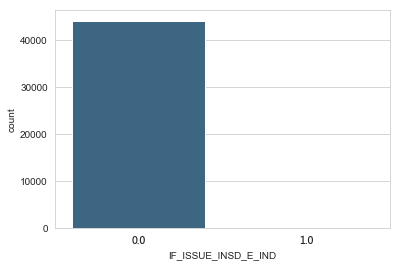

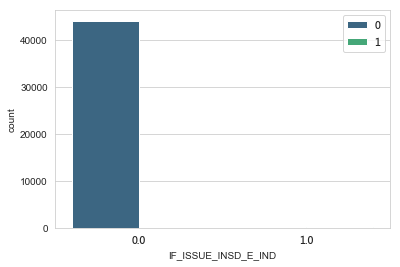

-------------------------------
0.0:
0    44188
1        2
Name: IF_ISSUE_E_IND, dtype: int64
0(%): 99.99547408916044
1(%): 0.004525910839556461
-------------------------------
nan:
0    12211
Name: IF_ISSUE_E_IND, dtype: int64
0(%): 100.0
-------------------------------
1.0:
1    136
0     10
Name: IF_ISSUE_E_IND, dtype: int64
0(%): 6.8493150684931505
1(%): 93.15068493150685


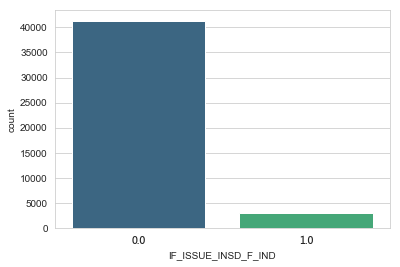

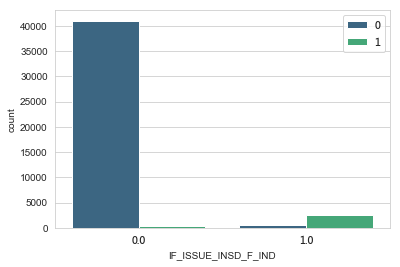

-------------------------------
0.0:
0    41009
1      334
Name: IF_ISSUE_F_IND, dtype: int64
0(%): 99.1921244225141
1(%): 0.8078755774859105
-------------------------------
1.0:
1    2510
0     483
Name: IF_ISSUE_F_IND, dtype: int64
0(%): 16.137654527230204
1(%): 83.86234547276979
-------------------------------
nan:
0    12158
1       53
Name: IF_ISSUE_F_IND, dtype: int64
0(%): 99.56596511342232
1(%): 0.43403488657767586


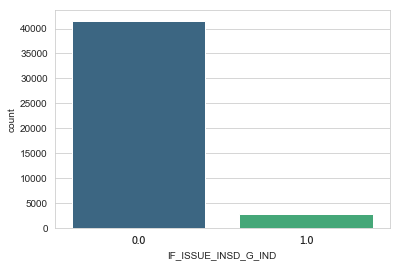

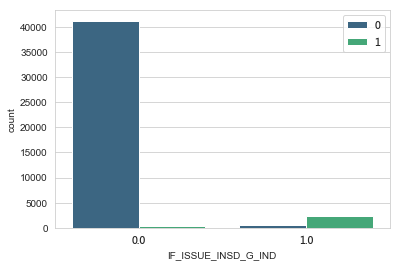

-------------------------------
0.0:
0    41232
1      339
Name: IF_ISSUE_G_IND, dtype: int64
0(%): 99.18452767554304
1(%): 0.8154723244569532
-------------------------------
nan:
0    12173
1       38
Name: IF_ISSUE_G_IND, dtype: int64
0(%): 99.68880517566129
1(%): 0.31119482433871104
-------------------------------
1.0:
1    2293
0     472
Name: IF_ISSUE_G_IND, dtype: int64
0(%): 17.070524412296564
1(%): 82.92947558770344


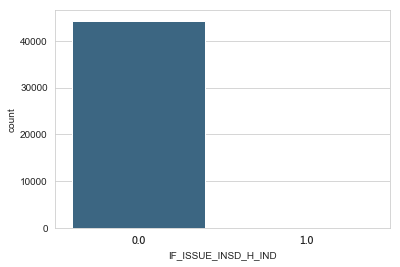

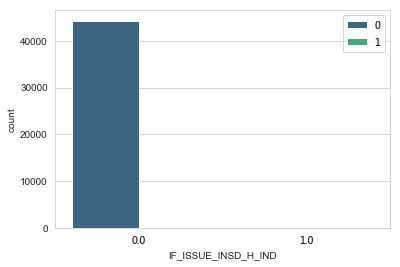

-------------------------------
0.0:
0    44302
Name: IF_ISSUE_H_IND, dtype: int64
0(%): 100.0
-------------------------------
nan:
0    12211
Name: IF_ISSUE_H_IND, dtype: int64
0(%): 100.0
-------------------------------
1.0:
1    34
Name: IF_ISSUE_H_IND, dtype: int64
1(%): 100.0


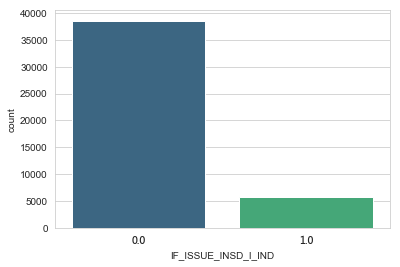

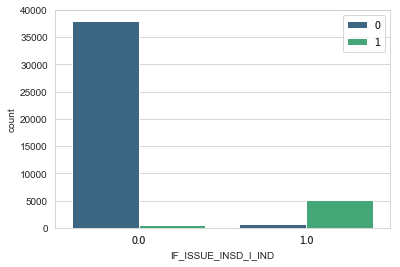

-------------------------------
0.0:
0    38043
1      526
Name: IF_ISSUE_I_IND, dtype: int64
0(%): 98.63621042806399
1(%): 1.363789571936011
-------------------------------
1.0:
1    5025
0     742
Name: IF_ISSUE_I_IND, dtype: int64
0(%): 12.866308305878274
1(%): 87.13369169412172
-------------------------------
nan:
0    12156
1       55
Name: IF_ISSUE_I_IND, dtype: int64
0(%): 99.54958643845713
1(%): 0.45041356154287115


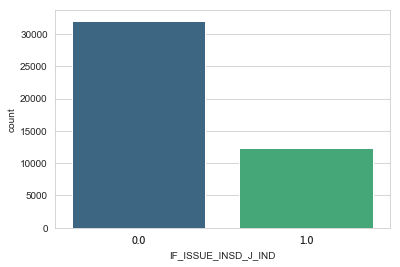

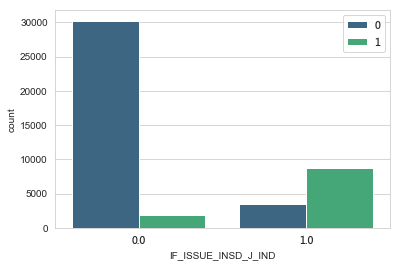

-------------------------------
0.0:
0    30230
1     1809
Name: IF_ISSUE_J_IND, dtype: int64
0(%): 94.35375635943693
1(%): 5.646243640563064
-------------------------------
nan:
0    11862
1      349
Name: IF_ISSUE_J_IND, dtype: int64
0(%): 97.14192121857342
1(%): 2.8580787814265824
-------------------------------
1.0:
1    8767
0    3530
Name: IF_ISSUE_J_IND, dtype: int64
0(%): 28.70618850126047
1(%): 71.29381149873953


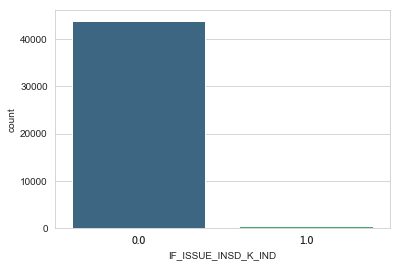

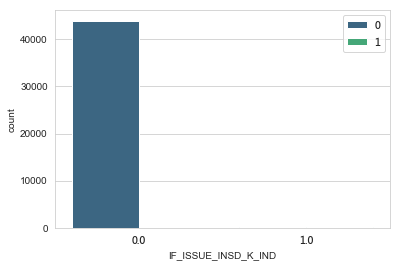

-------------------------------
0.0:
0    43923
1       39
Name: IF_ISSUE_K_IND, dtype: int64
0(%): 99.91128702060871
1(%): 0.08871297939129248
-------------------------------
nan:
0    12205
1        6
Name: IF_ISSUE_K_IND, dtype: int64
0(%): 99.95086397510441
1(%): 0.049136024895585946
-------------------------------
1.0:
1    210
0    164
Name: IF_ISSUE_K_IND, dtype: int64
0(%): 43.85026737967914
1(%): 56.14973262032086


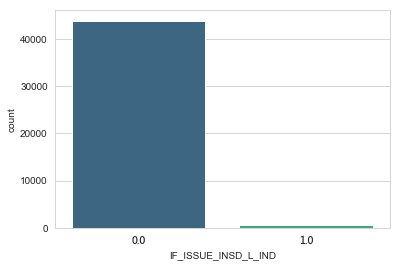

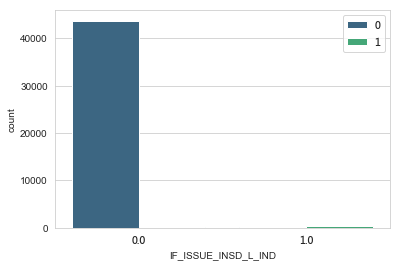

-------------------------------
0.0:
0    43723
1      109
Name: IF_ISSUE_L_IND, dtype: int64
0(%): 99.75132323416682
1(%): 0.2486767658331812
-------------------------------
nan:
0    12204
1        7
Name: IF_ISSUE_L_IND, dtype: int64
0(%): 99.94267463762182
1(%): 0.05732536237818361
-------------------------------
1.0:
1    417
0     87
Name: IF_ISSUE_L_IND, dtype: int64
0(%): 17.261904761904763
1(%): 82.73809523809523


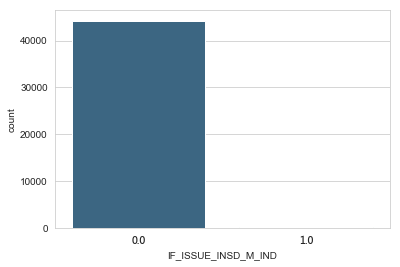

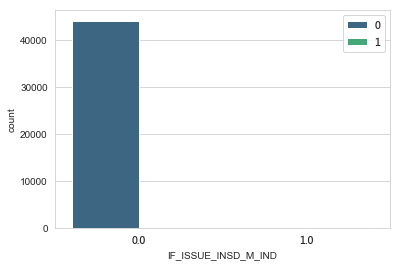

-------------------------------
0.0:
0    44225
1        8
Name: IF_ISSUE_M_IND, dtype: int64
0(%): 99.98191395564398
1(%): 0.018086044356023782
-------------------------------
nan:
0    12208
1        3
Name: IF_ISSUE_M_IND, dtype: int64
0(%): 99.97543198755221
1(%): 0.024568012447792973
-------------------------------
1.0:
1    89
0    14
Name: IF_ISSUE_M_IND, dtype: int64
0(%): 13.592233009708737
1(%): 86.40776699029125


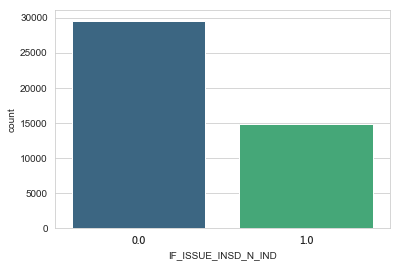

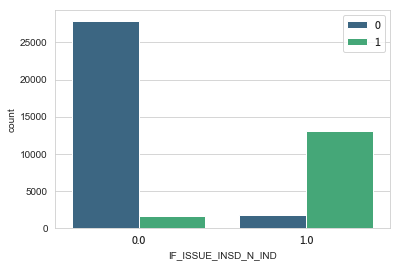

-------------------------------
1.0:
1    13102
0     1677
Name: IF_ISSUE_N_IND, dtype: int64
0(%): 11.347181812030584
1(%): 88.65281818796942
-------------------------------
0.0:
0    27938
1     1619
Name: IF_ISSUE_N_IND, dtype: int64
0(%): 94.52244815103022
1(%): 5.477551848969788
-------------------------------
nan:
0    11835
1      376
Name: IF_ISSUE_N_IND, dtype: int64
0(%): 96.92080910654329
1(%): 3.0791908934567194


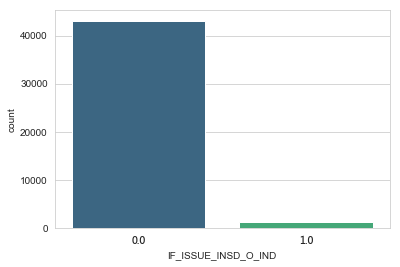

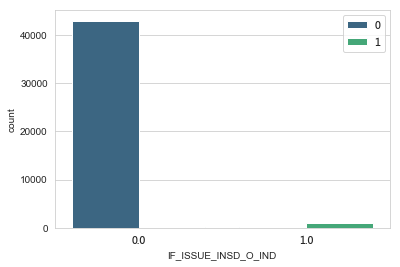

-------------------------------
0.0:
0    42986
1      100
Name: IF_ISSUE_O_IND, dtype: int64
0(%): 99.76790604836839
1(%): 0.23209395163162047
-------------------------------
nan:
0    12198
1       13
Name: IF_ISSUE_O_IND, dtype: int64
0(%): 99.89353861272623
1(%): 0.10646138727376955
-------------------------------
1.0:
1    1052
0     198
Name: IF_ISSUE_O_IND, dtype: int64
0(%): 15.840000000000002
1(%): 84.16


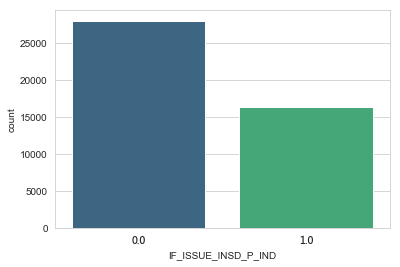

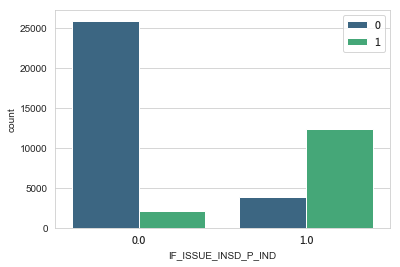

-------------------------------
0.0:
0    25881
1     2143
Name: IF_ISSUE_P_IND, dtype: int64
0(%): 92.35298315729375
1(%): 7.647016842706251
-------------------------------
1.0:
1    12401
0     3911
Name: IF_ISSUE_P_IND, dtype: int64
0(%): 23.976213830308975
1(%): 76.02378616969102
-------------------------------
nan:
0    11771
1      440
Name: IF_ISSUE_P_IND, dtype: int64
0(%): 96.39669150765702
1(%): 3.6033084923429692


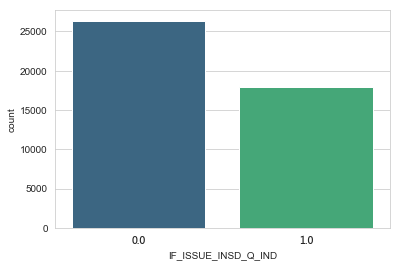

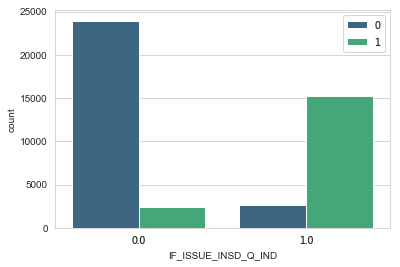

-------------------------------
0.0:
0    23945
1     2421
Name: IF_ISSUE_Q_IND, dtype: int64
0(%): 90.81771979063946
1(%): 9.18228020936054
-------------------------------
1.0:
1    15288
0     2682
Name: IF_ISSUE_Q_IND, dtype: int64
0(%): 14.924874791318866
1(%): 85.07512520868113
-------------------------------
nan:
0    11601
1      610
Name: IF_ISSUE_Q_IND, dtype: int64
0(%): 95.00450413561543
1(%): 4.995495864384571


In [412]:
# 此類別在多為(0,0)或(1,1)
for i in lst:
    count_and_percent("IF_ISSUE_INSD_{}_IND".format(i), train_mix, "IF_ISSUE_{}_IND".format(i))

In [718]:
# 目前主約被保有效件數(件)為0者剛好就是遺失的20083
train[train["LIFE_INSD_CNT"] == 0]["IF_ISSUE_INSD_A_IND"].value_counts()

Series([], Name: IF_ISSUE_INSD_A_IND, dtype: int64)

In [629]:
# 純被保險人此系列欄位仍傾向0較多
for i in lst:
    print(i)
    
    print(train_Insured["IF_ISSUE_INSD_{}_IND".format(i)].value_counts())
    print("----------------")

A
0.0    35183
1.0      398
Name: IF_ISSUE_INSD_A_IND, dtype: int64
----------------
B
0.0    34910
1.0      671
Name: IF_ISSUE_INSD_B_IND, dtype: int64
----------------
C
0.0    33269
1.0     2312
Name: IF_ISSUE_INSD_C_IND, dtype: int64
----------------
D
0.0    30550
1.0     5031
Name: IF_ISSUE_INSD_D_IND, dtype: int64
----------------
E
0.0    35567
1.0       14
Name: IF_ISSUE_INSD_E_IND, dtype: int64
----------------
F
0.0    34124
1.0     1457
Name: IF_ISSUE_INSD_F_IND, dtype: int64
----------------
G
0.0    34507
1.0     1074
Name: IF_ISSUE_INSD_G_IND, dtype: int64
----------------
H
0.0    35581
Name: IF_ISSUE_INSD_H_IND, dtype: int64
----------------
I
0.0    32238
1.0     3343
Name: IF_ISSUE_INSD_I_IND, dtype: int64
----------------
J
0.0    27383
1.0     8198
Name: IF_ISSUE_INSD_J_IND, dtype: int64
----------------
K
0.0    35423
1.0      158
Name: IF_ISSUE_INSD_K_IND, dtype: int64
----------------
L
0.0    35314
1.0      267
Name: IF_ISSUE_INSD_L_IND, dtype: int64
----------

# 和附約的關係

In [719]:
temporary_col2 = pd.read_csv("temporary_col.csv", index_col=0)

In [720]:
temporary_col2 = temporary_col2.loc[train_Insured.index]

In [721]:
for i in lst:    
    temporary_col2["IF_ISSUE_INSD_{}_IND".format(i)] = train_Insured["IF_ISSUE_INSD_{}_IND".format(i)]

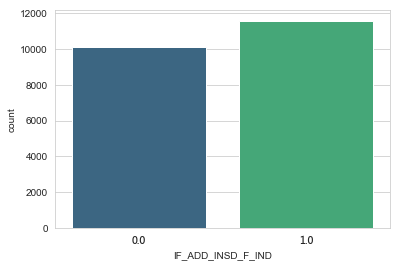

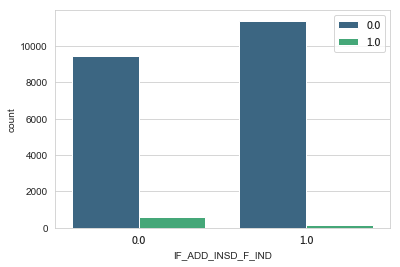

-------------------------------
nan:
0.0    13258
1.0      691
Name: IF_ISSUE_INSD_F_IND, dtype: int64
0.0(%): 95.04623987382608
1.0(%): 4.953760126173919
-------------------------------
1.0:
0.0    11394
1.0      168
Name: IF_ISSUE_INSD_F_IND, dtype: int64
0.0(%): 98.54696419304618
1.0(%): 1.4530358069538143
-------------------------------
0.0:
0.0    9472
1.0     598
Name: IF_ISSUE_INSD_F_IND, dtype: int64
0.0(%): 94.06156901688183
1.0(%): 5.938430983118173


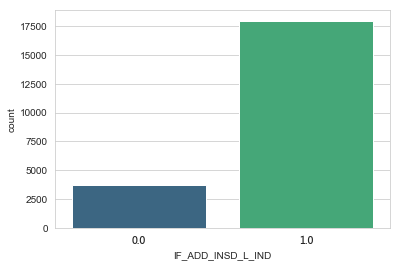

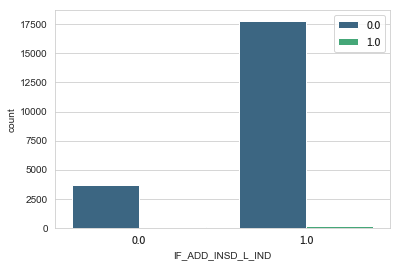

-------------------------------
nan:
0.0    13853
1.0       96
Name: IF_ISSUE_INSD_L_IND, dtype: int64
0.0(%): 99.31177862212344
1.0(%): 0.6882213778765502
-------------------------------
1.0:
0.0    17808
1.0      136
Name: IF_ISSUE_INSD_L_IND, dtype: int64
0.0(%): 99.2420864913063
1.0(%): 0.7579135086937138
-------------------------------
0.0:
0.0    3653
1.0      35
Name: IF_ISSUE_INSD_L_IND, dtype: int64
0.0(%): 99.05097613882863
1.0(%): 0.9490238611713666


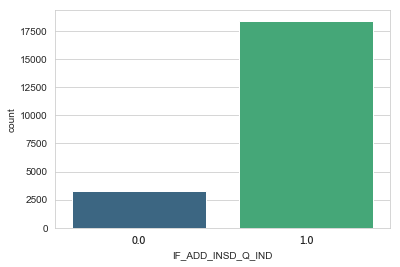

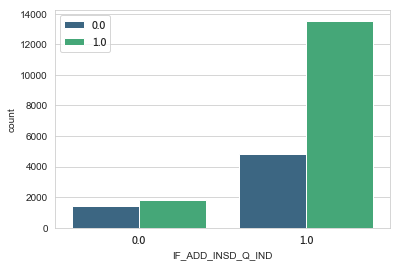

-------------------------------
nan:
0.0    12069
1.0     1880
Name: IF_ISSUE_INSD_Q_IND, dtype: int64
0.0(%): 86.52233134991756
1.0(%): 13.477668650082444
-------------------------------
1.0:
1.0    13539
0.0     4831
Name: IF_ISSUE_INSD_Q_IND, dtype: int64
0.0(%): 26.298312465977137
1.0(%): 73.70168753402287
-------------------------------
0.0:
1.0    1838
0.0    1424
Name: IF_ISSUE_INSD_Q_IND, dtype: int64
0.0(%): 43.654199877375845
1.0(%): 56.345800122624155


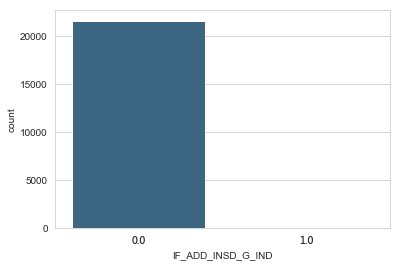

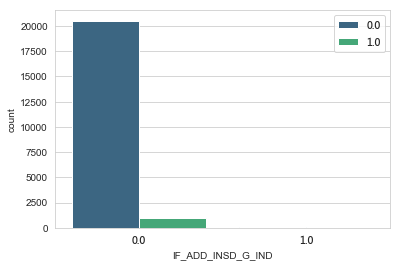

-------------------------------
nan:
0.0    13881
1.0       68
Name: IF_ISSUE_INSD_G_IND, dtype: int64
0.0(%): 99.51250985733743
1.0(%): 0.48749014266255647
-------------------------------
0.0:
0.0    20529
1.0      996
Name: IF_ISSUE_INSD_G_IND, dtype: int64
0.0(%): 95.37282229965157
1.0(%): 4.627177700348432
-------------------------------
1.0:
0.0    97
1.0    10
Name: IF_ISSUE_INSD_G_IND, dtype: int64
0.0(%): 90.65420560747664
1.0(%): 9.345794392523365


ValueError: Could not interpret input 'IF_ISSUE_INSD_R_IND'

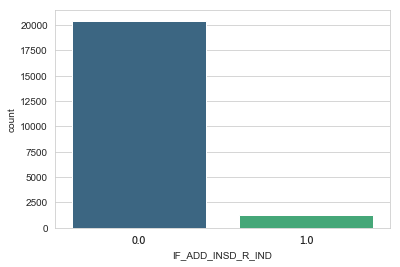

<Figure size 432x288 with 0 Axes>

In [722]:
lst2 = ["F", "L", "Q", "G", "R"]
for i in lst2:
    count_and_percent("IF_ADD_INSD_{}_IND".format(i), temporary_col2, "IF_ISSUE_INSD_{}_IND".format(i))

## 嘗試是否適合眾數法

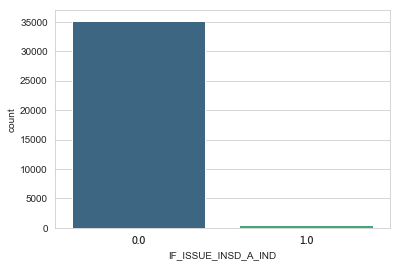

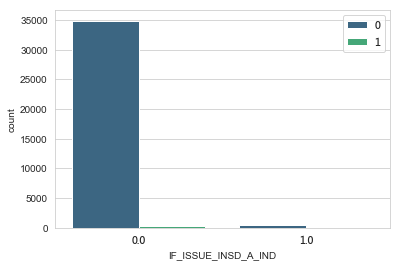

-------------------------------
0.0:
0    34887
1      296
Name: Y1, dtype: int64
0(%): 99.15868459199045
1(%): 0.8413154080095501
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862
-------------------------------
1.0:
0    393
1      5
Name: Y1, dtype: int64
0(%): 98.74371859296483
1(%): 1.256281407035176


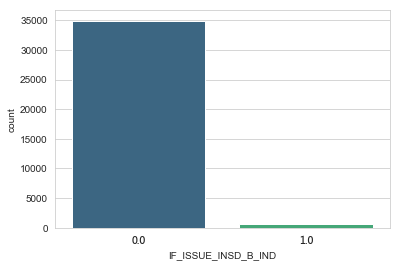

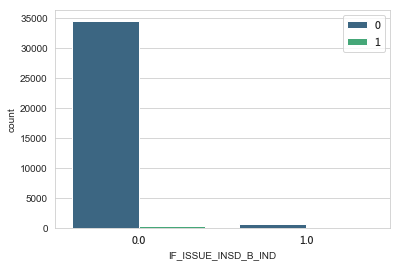

-------------------------------
0.0:
0    34620
1      290
Name: Y1, dtype: int64
0(%): 99.16929246634201
1(%): 0.8307075336579777
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862
-------------------------------
1.0:
0    660
1     11
Name: Y1, dtype: int64
0(%): 98.36065573770492
1(%): 1.639344262295082


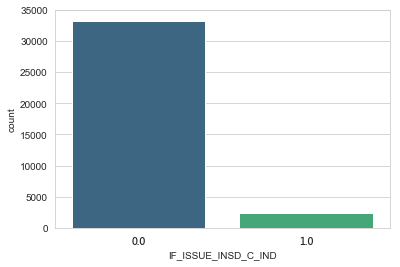

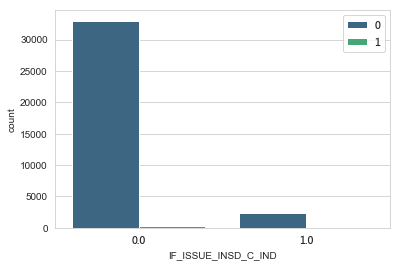

-------------------------------
0.0:
0    32998
1      271
Name: Y1, dtype: int64
0(%): 99.18542787580029
1(%): 0.8145721241997054
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862
-------------------------------
1.0:
0    2282
1      30
Name: Y1, dtype: int64
0(%): 98.70242214532871
1(%): 1.2975778546712802


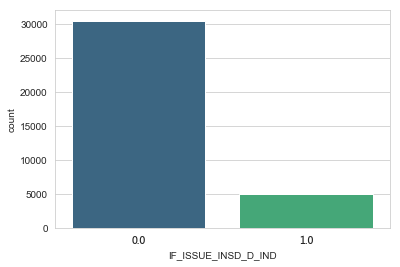

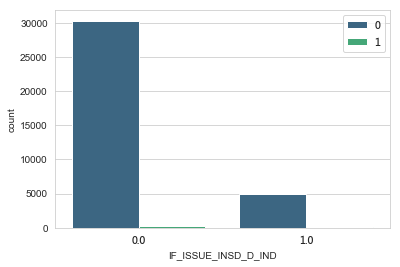

-------------------------------
0.0:
0    30303
1      247
Name: Y1, dtype: int64
0(%): 99.19148936170212
1(%): 0.8085106382978723
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862
-------------------------------
1.0:
0    4977
1      54
Name: Y1, dtype: int64
0(%): 98.92665474060823
1(%): 1.073345259391771


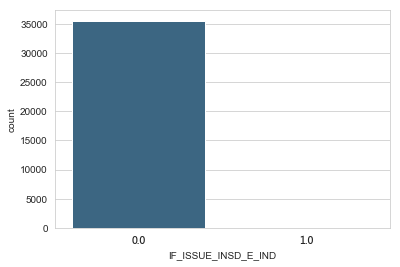

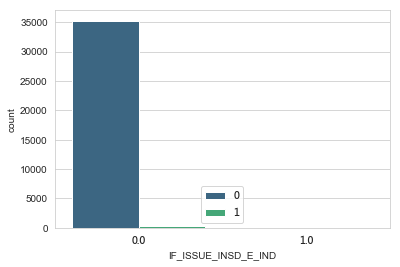

-------------------------------
0.0:
0    35266
1      301
Name: Y1, dtype: int64
0(%): 99.15370989962605
1(%): 0.8462901003739423
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862
-------------------------------
1.0:
0    14
Name: Y1, dtype: int64
0(%): 100.0


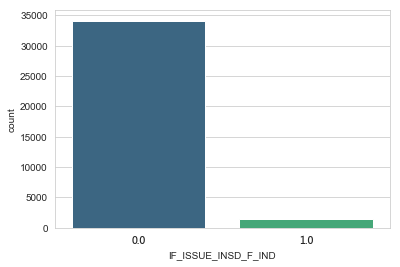

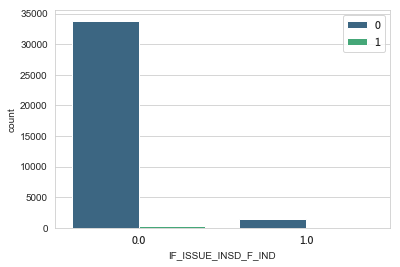

-------------------------------
0.0:
0    33837
1      287
Name: Y1, dtype: int64
0(%): 99.15894971281209
1(%): 0.841050287187903
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862
-------------------------------
1.0:
0    1443
1      14
Name: Y1, dtype: int64
0(%): 99.03912148249829
1(%): 0.9608785175017158


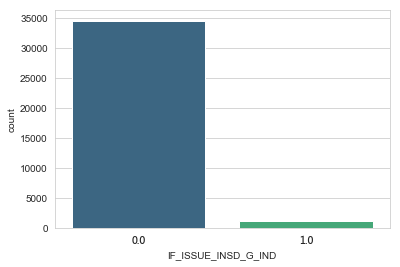

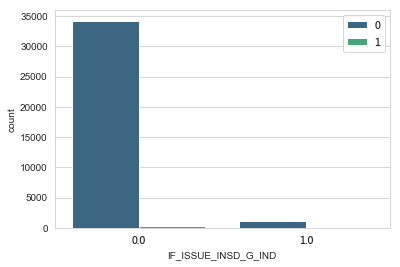

-------------------------------
0.0:
0    34220
1      287
Name: Y1, dtype: int64
0(%): 99.16828469585882
1(%): 0.8317153041411887
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862
-------------------------------
1.0:
0    1060
1      14
Name: Y1, dtype: int64
0(%): 98.69646182495345
1(%): 1.303538175046555


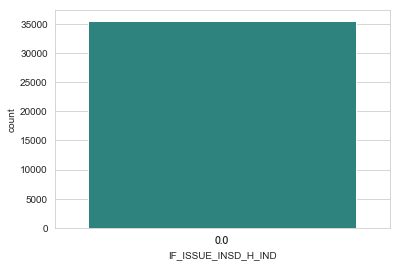

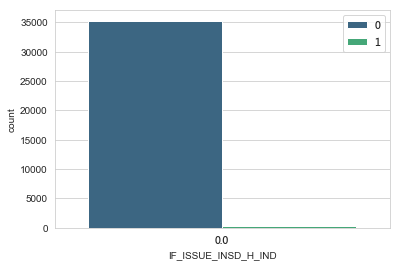

-------------------------------
0.0:
0    35280
1      301
Name: Y1, dtype: int64
0(%): 99.15404288805824
1(%): 0.8459571119417667
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862


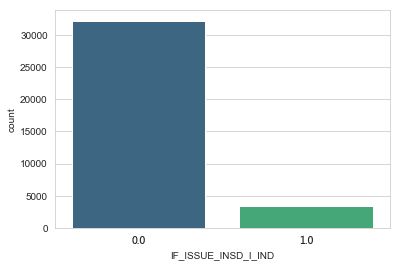

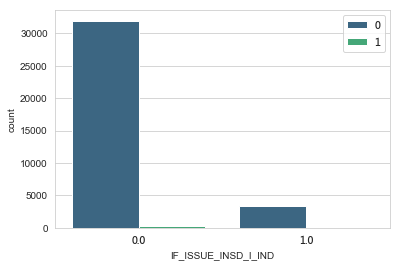

-------------------------------
0.0:
0    31963
1      275
Name: Y1, dtype: int64
0(%): 99.14696941497611
1(%): 0.8530305850238848
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862
-------------------------------
1.0:
0    3317
1      26
Name: Y1, dtype: int64
0(%): 99.22225545916841
1(%): 0.7777445408315884


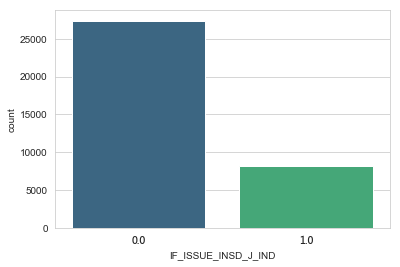

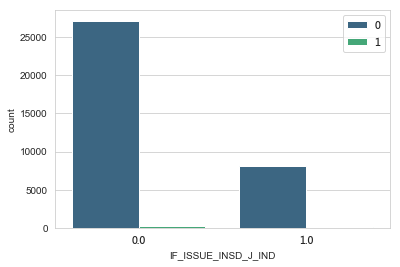

-------------------------------
0.0:
0    27164
1      219
Name: Y1, dtype: int64
0(%): 99.20023372165213
1(%): 0.79976627834788
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862
-------------------------------
1.0:
0    8116
1      82
Name: Y1, dtype: int64
0(%): 98.99975603805807
1(%): 1.000243961941937


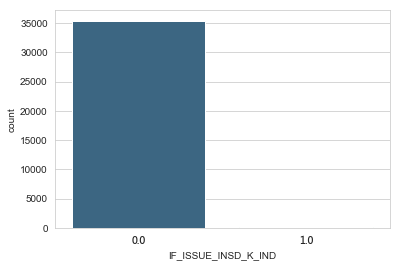

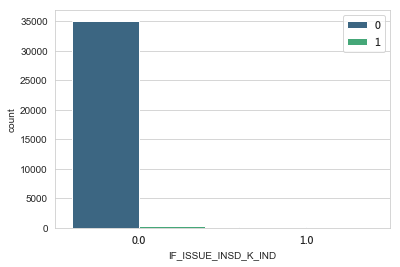

-------------------------------
0.0:
0    35124
1      299
Name: Y1, dtype: int64
0(%): 99.1559156480253
1(%): 0.8440843519747058
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862
-------------------------------
1.0:
0    156
1      2
Name: Y1, dtype: int64
0(%): 98.73417721518987
1(%): 1.2658227848101267


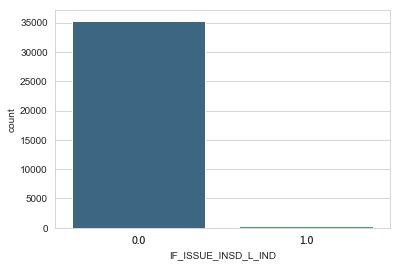

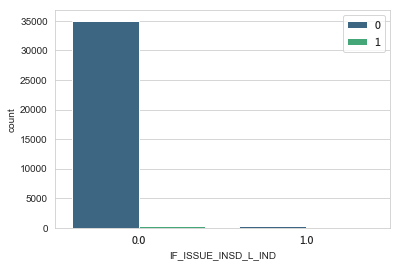

-------------------------------
0.0:
0    35016
1      298
Name: Y1, dtype: int64
0(%): 99.15614203998415
1(%): 0.8438579600158578
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862
-------------------------------
1.0:
0    264
1      3
Name: Y1, dtype: int64
0(%): 98.87640449438202
1(%): 1.1235955056179776


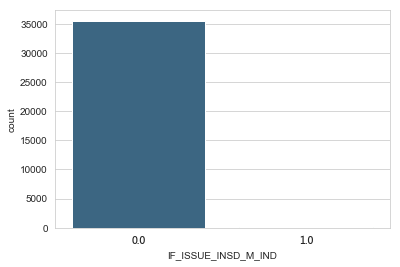

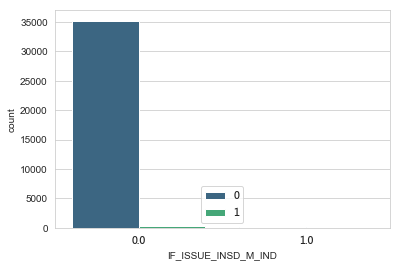

-------------------------------
0.0:
0    35218
1      301
Name: Y1, dtype: int64
0(%): 99.15256623215744
1(%): 0.8474337678425632
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862
-------------------------------
1.0:
0    62
Name: Y1, dtype: int64
0(%): 100.0


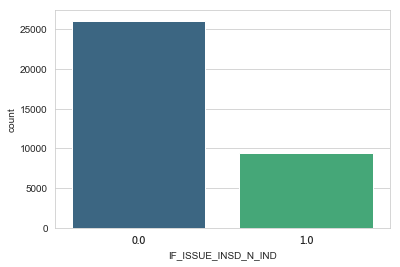

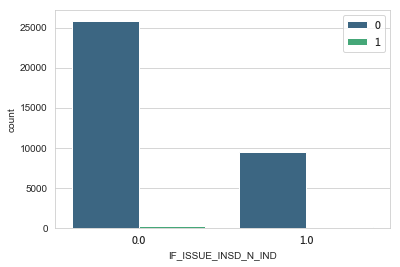

-------------------------------
1.0:
0    9425
1      49
Name: Y1, dtype: int64
0(%): 99.48279501794384
1(%): 0.5172049820561537
-------------------------------
0.0:
0    25855
1      252
Name: Y1, dtype: int64
0(%): 99.03474164017312
1(%): 0.9652583598268663
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862


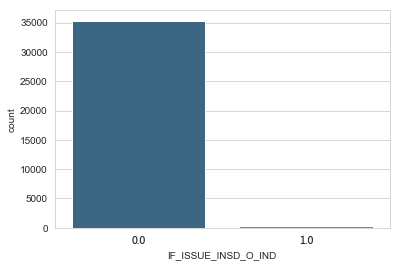

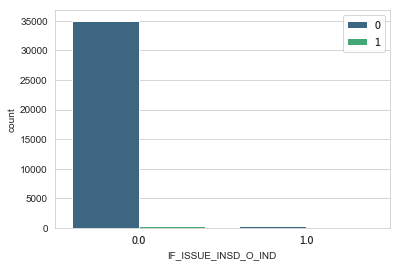

-------------------------------
0.0:
0    35028
1      298
Name: Y1, dtype: int64
0(%): 99.15642869274755
1(%): 0.8435713072524486
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862
-------------------------------
1.0:
0    252
1      3
Name: Y1, dtype: int64
0(%): 98.82352941176471
1(%): 1.1764705882352942


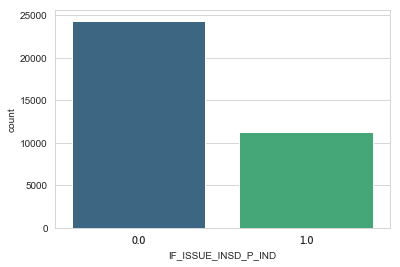

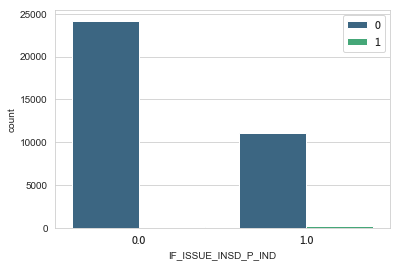

-------------------------------
1.0:
0    11084
1      153
Name: Y1, dtype: int64
0(%): 98.63842662632375
1(%): 1.361573373676248
-------------------------------
0.0:
0    24196
1      148
Name: Y1, dtype: int64
0(%): 99.39204732172199
1(%): 0.6079526782780151
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862


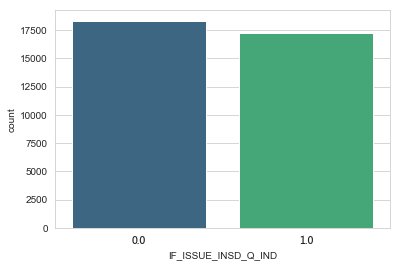

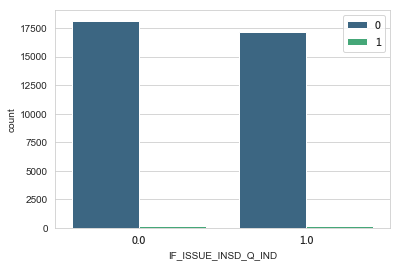

-------------------------------
0.0:
0    18147
1      177
Name: Y1, dtype: int64
0(%): 99.03405370006548
1(%): 0.9659462999345121
-------------------------------
1.0:
0    17133
1      124
Name: Y1, dtype: int64
0(%): 99.28145100538912
1(%): 0.7185489946108825
-------------------------------
nan:
0    7615
1      86
Name: Y1, dtype: int64
0(%): 98.88326191403713
1(%): 1.116738085962862


In [723]:

for i in lst:
    count_and_percent("IF_ISSUE_INSD_{}_IND".format(i), train_Insured, "Y1")

In [724]:
# EIMQ較特殊的圖=>EIM OK，怕Q會有較大偏誤
train_Insured["IF_ISSUE_INSD_Q_IND"].value_counts()

0.0    18324
1.0    17257
Name: IF_ISSUE_INSD_Q_IND, dtype: int64

## 處理

In [725]:
# 純被保人部分(眾數法)
for i in lst:
    train_Insured["IF_ISSUE_INSD_{}_IND".format(i)].fillna(0, inplace=True)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [726]:
# check
for i in lst:
    print(sum(train_Insured["IF_ISSUE_INSD_{}_IND".format(i)].value_counts()))

43282
43282
43282
43282
43282
43282
43282
43282
43282
43282
43282
43282
43282
43282
43282
43282
43282


In [727]:
# mix部分
def mix_IF_ISSUE_INSD_impute(cols):
    
    IF_ISSUE_IND = cols[0]
    IF_ISSUE_INSD_IND = cols[1]
    
    if pd.isnull(IF_ISSUE_INSD_IND):
        
        if IF_ISSUE_IND == 0:
            return 0
        
        else:
            return 1
    else:
        return IF_ISSUE_INSD_IND
        

In [728]:
for i in lst:
    train_mix["IF_ISSUE_INSD_{}_IND".format(i)] = train_mix[["IF_ISSUE_{}_IND".format(i), "IF_ISSUE_INSD_{}_IND".format(i)]].apply(mix_IF_ISSUE_INSD_impute, axis=1)

In [729]:
# check
for i in lst:
    print(sum(train_mix["IF_ISSUE_INSD_{}_IND".format(i)].value_counts()))

56547
56547
56547
56547
56547
56547
56547
56547
56547
56547
56547
56547
56547
56547
56547
56547
56547


In [730]:
for i in lst:
    train["IF_ISSUE_INSD_{}_IND".format(i)] = pd.concat([train_mix, train_Insured, train_Applicant])["IF_ISSUE_INSD_{}_IND".format(i)]

In [731]:
train.info(max_cols=150)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 3418 to 1994377
Data columns (total 102 columns):
GENDER                       100000 non-null float64
AGE                          100000 non-null int64
CHARGE_CITY_CD               100000 non-null int64
CONTACT_CITY_CD              100000 non-null int64
EDUCATION_CD                 100000 non-null float64
MARRIAGE_CD                  100000 non-null float64
LAST_A_CCONTACT_DT           100000 non-null int64
L1YR_A_ISSUE_CNT             100000 non-null int64
LAST_A_ISSUE_DT              100000 non-null int64
L1YR_B_ISSUE_CNT             100000 non-null int64
LAST_B_ISSUE_DT              100000 non-null int64
CHANNEL_A_POL_CNT            100000 non-null int64
CHANNEL_B_POL_CNT            100000 non-null int64
OCCUPATION_CLASS_CD          100000 non-null float64
APC_CNT                      100000 non-null int64
INSD_CNT                     100000 non-null int64
APC_1ST_AGE                  100000 non-null float64
INSD_1S

# 刪除剩餘有遺失值資料

In [732]:
# 共刪除242的顧客資料
del_rows = train[pd.isnull(train["INSD_1ST_AGE"])|pd.isnull(train["LEVEL"])|pd.isnull(train["RFM_R"])|pd.isnull(train["X_A_IND"])]
print(len(del_rows))

242


In [733]:
train.drop(del_rows.index, inplace=True)

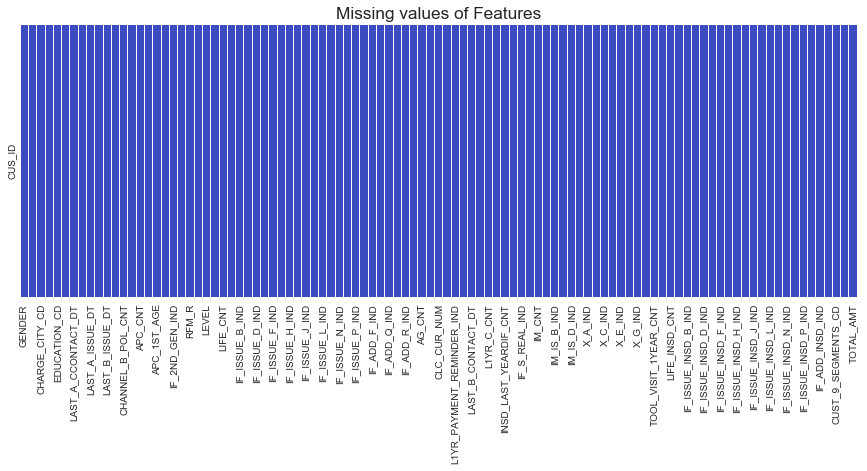

In [734]:
# Nan figure(red:Nan) of train
plt.figure(figsize=[15, 5])
plt.title("Missing values of Features", fontdict={"fontsize":"xx-large"})
sns.heatmap(train.drop("Y1", axis=1).isnull(), yticklabels=False, cbar=False, cmap="coolwarm")

In [736]:
# 有遺失值欄位個數
len(train.columns[pd.isnull(train).sum() != 0])

0

In [737]:
# drop numbers_of_null
train.drop("numbers_of_null", axis=1, inplace=True)

In [738]:
train.to_csv("train_cleaned_version1.csv")

In [739]:
# check
# pd.read_csv("train_cleaned_version1.csv", index_col=0)

,GENDER,AGE,CHARGE_CITY_CD,CONTACT_CITY_CD,EDUCATION_CD,MARRIAGE_CD,LAST_A_CCONTACT_DT,L1YR_A_ISSUE_CNT,LAST_A_ISSUE_DT,L1YR_B_ISSUE_CNT,...,IF_ISSUE_INSD_M_IND,IF_ISSUE_INSD_N_IND,IF_ISSUE_INSD_O_IND,IF_ISSUE_INSD_P_IND,IF_ISSUE_INSD_Q_IND,IF_ADD_INSD_IND,L1YR_GROSS_PRE_AMT,CUST_9_SEGMENTS_CD,Y1,TOTAL_AMT
CUS_ID,,,,,,,,,,,,,,,,,,,,,
3418,1.0,1,1,1,0.0,0.0,1,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.000174,3,0,0.008440
4302,1.0,1,1,1,0.0,0.0,1,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.008724,1,0,0.008440
5545,1.0,1,1,1,1.0,0.0,1,1,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.005359,1,0,0.000000
7207,1.0,1,1,1,0.0,0.0,1,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,3,0,0.008440
7213,1.0,1,1,1,1.0,0.0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.000603,3,0,0.047170
8818,1.0,1,1,1,0.0,0.0,1,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.000243,3,0,0.008440
9681,1.0,1,1,1,0.0,0.0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.002600,1,0,0.008440
9743,1.0,1,1,1,0.0,0.0,1,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.002887,1,0,0.008440
9839,1.0,1,1,1,1.0,0.0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.000140,3,0,0.686849
